# Первичное исследование данных

Перед нами стоит задача в разработке модели машинного обучения, которая смогла бы предсказать стоимость объекта жилой недвижимости  по подаваемым в модель его признакам.

Работать предстоит с датасетом, содержащим базу данных по объектам недвижимости в США.

In [1]:
# Импортируем необходимые для работы библиотеки

import pandas as pd
import numpy as np
import re
import statistics as st

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

import category_encoders as ce
from scipy.stats import shapiro, normaltest 
import sklearn.metrics as metrics
from sklearn import feature_selection
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
import optuna

/tmp/ipykernel_4491/1290784231.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #установка стиля matplotlib


## Ознакомление с данными

In [2]:
data = pd.read_csv('data/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [3]:
data.head()

status private pool        propertyType               street    baths  \
0    Active          NaN  Single Family Home       240 Heather Ln      3.5   
1  for sale          NaN  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home    2005 Westridge Rd  2 Baths   
3  for sale          NaN  single-family home  4311 Livingston Ave  8 Baths   
4  for sale          NaN            lot/land       1524 Kiscoe St      NaN   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...       yes   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   
3          Dallas  [{'rating': ['9/10', '9/10', '10/10', '9/10'],...   
4        Palm Bay  [{'rating': ['4/10', '5/10', '5/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   
3  6,457 sqft   75205  5 Beds    TX     3.0    NaN         NaN    14191809   
4         NaN   32908     NaN    FL     NaN    NaN         NaN      861745   

       target  
0    $418,000  
1    $310,000  
2  $2,895,000  
3  $2,395,000  
4      $5,000

In [4]:
# Посмотрим на пропуски в данных (в процентах)
data.isnull().sum().sort_values(ascending=False) / len(data) * 100

private pool    98.891525
mls-id          93.387330
PrivatePool     89.312672
fireplace       72.661956
stories         39.957846
baths           28.192532
beds            24.200856
MlsId           17.731352
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
zipcode          0.000000
schools          0.000000
state            0.000000
homeFacts        0.000000
dtype: float64

Первичное ознакомление с датасетом показало, что данные очень "сырые" и требуют серьезной предобработки до подачи их в модель.

Судя по всему, большая часть данных заносились в базу вручную и разными людьми. Вместо выбора из списка унифицированных параметров объекта недвижимости, использовался ручной ввод с клавиатуры, а потому в строках полно лишних символов, ошибок, опечаток, сокращений, профессионального жаргона, разных вариантов написания одних и тех данных и т.п.

Кроме того, большинство признаков имеет пропуски (в некоторых из них число пропусков превышает 90%). 

Все данные представлены в строковом формате, типа object. Хотя на самом деле среди них можно выделить и бинарные и числовые и категориальные признаки. Чтобы это сделать, придется сперва очистить данные от мусора и понять логику заполнения полей в карточках объектов недвижимости.

Особенно интересны для исследования признаки homeFacts и schools, каждый из которых внутри себя содержит словарь с несколькими дополнитеьными признаками по каждому объекту недвижимости. 

### Расшифровка признаков из словаря в признаке homeFacts

Признак homeFacts внутри себя содержит словарь с несколькими дополнитеьными характеристиками объектов недвижимости - год постройки, год реконструкции, система отопления, система охлаждения, наличие парковки, площадь участка, цена за кв.фут.

Использование в качестве дополнительного признака цены за кв.фут в построении модели может привести к утечке данных, так как она напрямую связана с целевым признаком. Поэтому извлекать эти данные из словаря не будем.

Остальные признаки могут быть важны для оценки стоимости недвижимости, попробуем на данном этапе вынести их в отдельные признаки.

In [5]:
# Сперва преобразуем строку в словарь 
data.homeFacts = data.homeFacts.apply(lambda x: eval(x[19:-1]))

# Зададим список с названиями новых признаков
col_names = ['year_built', 'remodeled_year', 'heating', 'cooling', 'parking', 'lotsize']

# С помощью цикла извлекаем значения из словаря и создаем из них новые признаки в датасете
for i, col_name in enumerate(col_names):
    data[col_name] = data['homeFacts'].apply(lambda x: x[i].get('factValue'))

### Неинформативные признаки

I. Совершенно не понятно, как можно использовть признаки **mls-id** и **MlsId**. Ясно, что в них указаны ID объектов недвижимости при их добавлении в систему MLS, и по логике с их помощью можно было бы отследить все движение по объекту недвижимости (изменение его статусов, цены, каких-то характеристик) и это помогло бы исключить дубли в записях и позволило бы собрать максимально полную картину по конкретному объекту... 

К сожалению, в ТЗ не прописано, как читать эти ID-коды, а самому в этом разобраться не реально - кодировка не имеет какого-то унифицированного шаблона (видимо у каждого агентства недвижимости она своя), есть и неуникальные ID, которые собраны, например, из почтового кода и штата, а 17% объектов коды не присвоены вовсе.

Принимаю решение сразу удалить эти признаки из датасета и дальше работать без них.  

II. Исходный признак **homeFacts** для дальнейшей работы нам больше не нужен. Его тоже удалим.

In [6]:
# Удалим неинформативные признаки
data.drop(['mls-id', 'MlsId', 'homeFacts'], axis=1, inplace=True)

In [7]:
# Посмотрим, как выглядят данные теперь
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   status          337267 non-null  object
 1   private pool    4181 non-null    object
 2   propertyType    342452 non-null  object
 3   street          377183 non-null  object
 4   baths           270847 non-null  object
 5   fireplace       103115 non-null  object
 6   city            377151 non-null  object
 7   schools         377185 non-null  object
 8   sqft            336608 non-null  object
 9   zipcode         377185 non-null  object
 10  beds            285903 non-null  object
 11  state           377185 non-null  object
 12  stories         226470 non-null  object
 13  PrivatePool     40311 non-null   object
 14  target          374704 non-null  object
 15  year_built      373572 non-null  object
 16  remodeled_year  350616 non-null  object
 17  heating         373652 non-nu

## Предобработка данных

На данном этапе разберемся с каждым из имеющихся признаков. Очистим данные от мусора, приведем к наиболее подходящему типу данных, проанализируем, какую полезную информацию можем взять из признаков для построения модели машинного обучения.

### Целевой признак target

Вся наша работа по ТЗ сводится к решению задачи регресии - предсказанию цены объекта недвижимости на основе переданного алгоритму набора факторов (признаков объекта недвижимости из датасета) и вектора правильных ответов (это и есть признак target).

Для подачи в модель нужно очистить признак от лишних символов, отсеять наблюдения с пропусками, проанализировать распределение целевого признака на наличие выбросов и аномальных значений.

In [8]:
# С помощью регулярных выражений вытащим символы, которые указываются в целевом признаке кроме самой цены
data['target_sym'] = data['target'].apply(lambda x: re.sub("[0-9]", "", str(x)))
data['target_sym'].unique()

array(['$,', '$,,', ',', ',,', '$,+', 'nan', '$,/mo', '$,,+', '$', '$/mo',
       '', '$, - $,/mo'], dtype=object)

Видим, что есть логика в написании цены - разряды чисел разделяются запятой, в начале строки может указываться знак доллара, в конце может быть знак + (видимо, это значит, что рассматриваются предложения от указанной цены и выше).

Некоторые строки имеют окончание /mo, так обозначают цену за месяц и речь в данном случае идет об аренде. Такие наблюдения нам не подходят для прогноза, их следует удалить.

In [9]:
# Уберем из датасета объекты, которые сдаются в аренду, и объекты без цены (NaN)
data = data[
    (data['target_sym'] != '$,/mo') 
    & (data['target_sym'] != '$/mo') 
    & (data['target_sym'] != '$, - $,/mo') 
    & (data['target_sym'] != 'nan')
    ]
data.reset_index(drop=True, inplace=True)

# Избавимся от лишних символов в признаке цены и приведем данные к типу Int
data['target'] = data['target'].apply(lambda x: str(x).replace('$','').replace(',','').replace('+',''))
data['target'] = data['target'].astype(int)

# Удалим временный признак target_sym
data.drop(['target_sym'], axis=1, inplace=True)

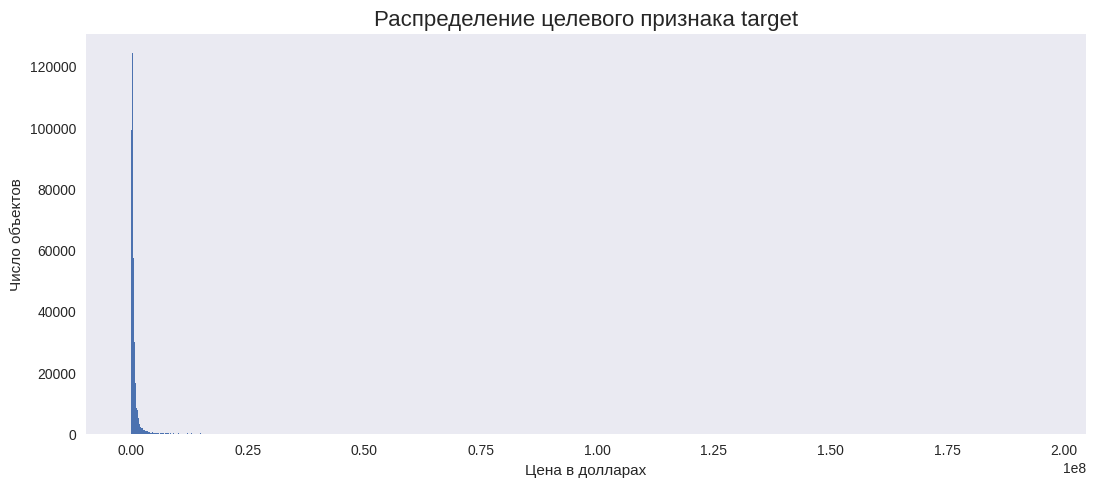

In [10]:
# Построим гистограмму распределения целевого признака
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0,0,1,1])
axes.hist(
    data['target'],
    bins=1000
)
axes.set_title('Распределение целевого признака target', fontsize=16)
axes.set_xlabel('Цена в долларах')
axes.set_ylabel('Число объектов')
axes.grid();

Из-за очень большого разброса в цене график почти нечитабельный. Попробуем взять срез данных, чтобы лучше оценить распределение цены.

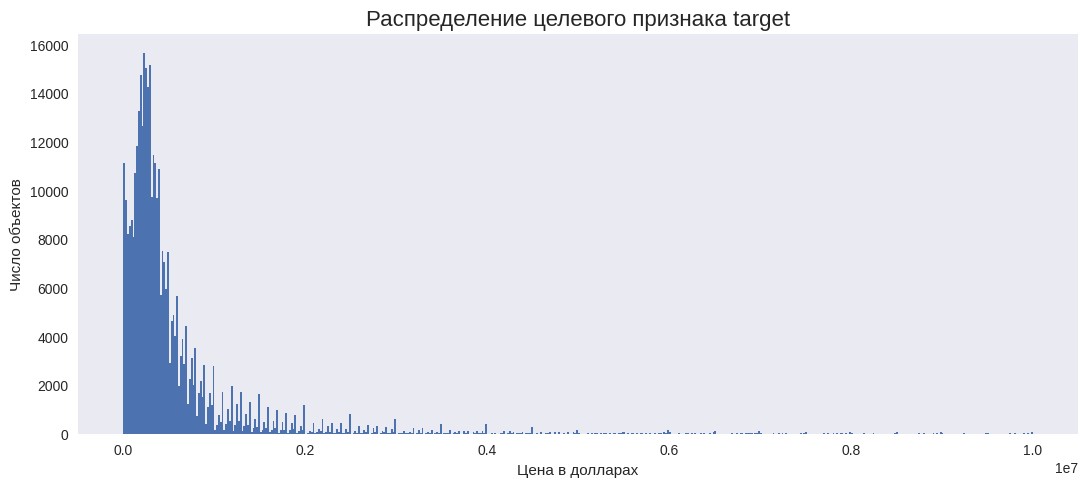

In [11]:
# Построим гистограмму распределения целевого признака для лотов с ценой до 10000000$
data_temp = data[data['target'] < 10000000]

fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0,0,1,1])
axes.hist(
    data_temp['target'],
    bins=500
)
axes.set_title('Распределение целевого признака target', fontsize=16)
axes.set_xlabel('Цена в долларах')
axes.set_ylabel('Число объектов')
axes.grid();

In [12]:
data_temp.target.describe()

count    3.726880e+05
mean     5.596778e+05
std      8.627976e+05
min      1.000000e+00
25%      1.864990e+05
50%      3.199790e+05
75%      5.750000e+05
max      9.999999e+06
Name: target, dtype: float64

Теперь хорошо видно, что распределение не нормально, а строится экспоненциально с очень длинным хвостом вправо. При этом 75% объектов выставлено в ценовом диапазоне до 575 тыс долларов.

In [13]:
# Уберем из датасета объекты с аномально низкой ценой менее 1000$
data = data[data['target'] > 1000]

In [14]:
# Посмотрим на самые дорогие объекты в базе
data[data['target'] > 100000000]

status private pool        propertyType               street  \
53762   for sale          NaN  single-family home  2571 Wallingford Dr   
109251  for sale          NaN  single-family home         Tortuoso Way   
118950  For sale          NaN       Single Family   141 S Carolwood Dr   
131427  For sale          NaN       Single Family         875 Nimes Rd   
142452  for sale          NaN  single-family home   67 Beverly Park Ct   
177578  For sale          NaN       Single Family        9505 Lania Ln   
283843  For sale          NaN       Single Family   67 Beverly Park Ct   
292000  for sale          NaN  single-family home   141 S Carolwood Dr   
351567  for sale          NaN            lot/land       1441 Angelo Dr   

           baths fireplace           city  \
53762   24 Baths       yes  Beverly Hills   
109251       NaN       NaN    Los Angeles   
118950      10.0       Yes    Los Angeles   
131427      18.0       Yes    Los Angeles   
142452  23 Baths       yes  Beverly Hills   
177578      23.0       Yes  Beverly Hills   
283843      23.0       Yes  Beverly Hills   
292000  10 Baths       yes    Los Angeles   
351567       NaN       NaN  Beverly Hills   

                                                  schools         sqft  \
53762   [{'rating': ['7/10', '5/10', '10/10'], 'data':...  38,000 sqft   
109251  [{'rating': ['7/10', '5/10', '10/10'], 'data':...          NaN   
118950  [{'rating': ['10/10', '5/10', '7/10'], 'data':...       12,201   
131427  [{'rating': ['10/10', '7/10'], 'data': {'Dista...           --   
142452  [{'rating': ['7/10', '5/10', '10/10'], 'data':...  28,660 sqft   
177578  [{'rating': ['10/10', '5/10', '7/10'], 'data':...       43,000   
283843  [{'rating': ['10/10', '5/10', '7/10'], 'data':...       28,660   
292000  [{'rating': ['7/10', '5/10', '10/10'], 'data':...  12,201 sqft   
351567  [{'rating': ['7/10', '5/10', '10/10'], 'data':...     741 sqft   

       zipcode  ... state stories PrivatePool     target  year_built  \
53762    90210  ...    CA     2.0         yes  110000000        2000   
109251   90077  ...    CA     NaN         yes  150000000               
118950   90077  ...    CA       3         Yes  115000000        1936   
131427   90077  ...    CA       2         Yes  195000000        1935   
142452   90210  ...    CA     3.0         yes  165000000        1998   
177578   90210  ...    CA       3         Yes  129000000        2002   
283843   90210  ...    CA       3         Yes  165000000        1998   
292000   90077  ...    CA     3.0         yes  115000000        1936   
351567   90210  ...    CA     NaN         NaN  110000000        2007   

       remodeled_year     heating  cooling          parking      lotsize  
53762            2000  Forced Air  Central          Carport    5.2 acres  
109251                                                       10.51 acres  
118950           1946  Forced air  Central          No Data    9.9 acres  
131427           None  Forced air  Central        40 spaces   6.49 acres  
142452           1998  Forced Air  Central  Attached Garage   5.43 acres  
177578           2005  Forced air  Central        27 spaces  24.86 acres  
283843           1998  Forced air  Central  Attached Garage   9.87 acres  
292000           1946  Forced Air  Central                    3.87 acres  
351567                                None                   13.24 acres  

[9 rows x 21 columns]

Делаю вывод, что самые дорогие лоты - это реальные объекты в самых престижных районах Америки. Но такие данные очень сильно портят общую картину для анализа и скорее всего будут аномальными при построении прогноза.

Проверим распределение на выбросы по методу z-отклонений. Для этого сперва логарифмируем целевой признак и посмотрим на его распределение.

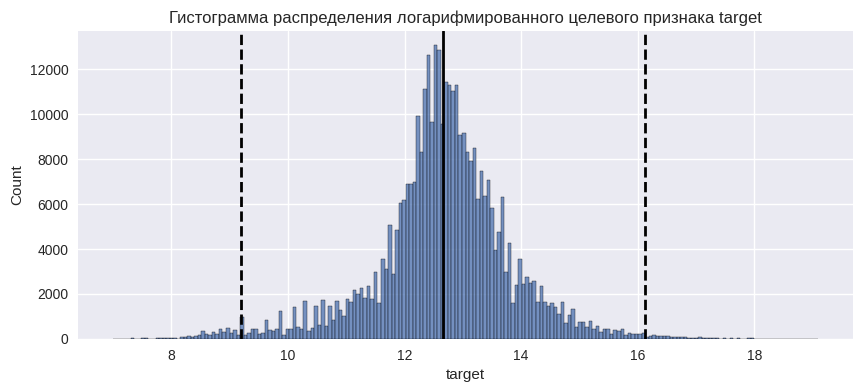

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
log_sqft = np.log(data['target'])
histplot = sns.histplot(log_sqft, bins=200, ax=ax)
histplot.axvline(log_sqft.mean(), color='k', lw=2)
histplot.axvline(log_sqft.mean() + 3 *log_sqft.std(), color='k', ls='--', lw=2)
histplot.axvline(log_sqft.mean() - 3 *log_sqft.std(), color='k', ls='--', lw=2)
histplot.set_title('Гистограмма распределения логарифмированного целевого признака target');

Распределение стало похожим на нормальное. За границы 3-х стандартных отклонений попала небольшая доля объектов с аномально низкой или наоборот высокой ценой. 

In [16]:
def find_outliers_z_score(data, feature, left=3, right=3, log_scale=False):
    """
    Находит выбросы в данных, используя метод z-отклонений. 
    Классический метод модифицирован путем добавления:
    * возможности логарифмирования распредления
    * ручного управления количеством стандартных отклонений в обе стороны распределения
    Args:
        data (pandas.DataFrame): набор данных
        feature (str): имя признака, на основе которого происходит поиск выбросов.
        left (float, optional): количество стандартных отклонений в левую сторону распределения.
        right (float, optional): количество стандартных отклонений в правую сторону распределения.
        log_scale (bool, optional): режим логарифмирования. По умолчанию False - логарифмирование не применяется.

    Returns:
        pandas.DataFrame: наблюдения, попавшие в разряд выбросов
        pandas.DataFrame: очищенные данные, из которых исключены выбросы
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [17]:
outliers, cleaned = find_outliers_z_score(data, 'target', left=3, right=3, log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 5839
Результирующее число записей: 367425


In [18]:
cleaned['target'].describe()

count    3.674250e+05
mean     5.686514e+05
std      8.716572e+05
min      9.850000e+03
25%      1.924900e+05
50%      3.250000e+05
75%      5.850000e+05
max      1.000000e+07
Name: target, dtype: float64

Таким образом по методу z отклонений в выбросы попали объекты с ценой менее 10000 долларов и дороже 10 млн долларов. Cчитаю, что получили вполне адекватные границы для недвижимости. Очистим датасет от этих объектов.

In [19]:
data = cleaned.copy()

### Признак status

In [20]:
# Так как имеем много уникальных значений, приведем все к нижнему регистру
data['status'] = data['status'].apply(lambda x: str(x).lower())

In [21]:
# Отфильтруем объекты, выставленные в аренду, а также уже проданные, и очистим от них датасет
data['status'] = data['status'].apply(lambda x: 'rent' if 'for rent' in str(x) else x)
data['status'] = data['status'].apply(lambda x: 'closed' if ('closed' in str(x) or 'sold' in str(x)) else x)

data = data[(data['status'] != 'rent') & (data['status'] != 'closed')]
data.reset_index(drop=True, inplace=True)

In [22]:
# Преобразуем пропуски и значения с nan в категорию unknown
data['status'] = data['status'].apply(lambda x: 'unknown' if 'nan' in str(x) else x)
data.loc[(data['status'].isnull() == True), 'status'] = 'unknown'

In [23]:
# Сгруппируем данные в признаке на несколько категорий
data['status'] = data['status'].apply(lambda x: 'new' if ('coming soon' in str(x) or 'new' in str(x)) else x)
data['status'] = data['status'].apply(lambda x: 'pre_foreclosure' if ('pre-for' in str(x) or 'auction' in str(x)  or 'pf' in str(x)) else x)
data['status'] = data['status'].apply(lambda x: 'under_contract' if ('contract' in str(x) or 'pending' in str(x) or 'contingen' in str(x) or 'offer' in str(x) or 'backup' in str(x)) else x)
data['status'] = data['status'].apply(lambda x: 'active' if ('for sale' in str(x) or 'activ' in str(x)) else x)

# Оставшиеся значения также разобьем на выделенные ранее группы
under_contract_list = ['p', 'c', 'pi', 'ct', 'ps', 'active option', 'due diligence period', 'c continue show', 'uc continue to show']
for i in under_contract_list:
    data.loc[(data['status'] == i), 'status'] = 'under_contract'
    
active_list = ['price change', 'back on market', 'listing extended', 'lease/purchase']
for i in active_list:
    data.loc[(data['status'] == i), 'status'] = 'active'

In [24]:
data.status.value_counts()

active             300526
unknown             39205
under_contract      11495
new                  6240
foreclosure          5052
pre_foreclosure      4614
Name: status, dtype: int64

### Признак propertyType

Тип недвижимости - один из важнейших признаков для оценки недвижимости фактор. Это может быть частный дом или многоквартирный, а также еще много различных подкатегорий, которые нужно разобрать.

In [25]:
data.propertyType.value_counts()

single-family home                                             89937
Single Family                                                  61267
Single Family Home                                             31661
condo                                                          25634
lot/land                                                       18627
                                                               ...  
Loft, Warehouse                                                    1
1 Story, Contemporary, Other (See Remarks)                         1
Contemporary, Modernist, Ranch, Rustic                             1
Contemporary, Farmhouse                                            1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: propertyType, Length: 1277, dtype: int64

Значения в признаке неунифицированы, видимо заносились вручную, а потому имеем множесто вариаций одних и тех же категорий, ошибки, сокращения... Кроме того, в признаке кроме типа недвижимости часто указывается архетектурный стиль, число этажей или какие-либо особенности дома. В исходном виде эти данные использовать нельзя.

In [26]:
# Так как очень много уникальных значений, сперва приведем все к нижнему регистру и уберем лишние символы из строк
data['propertyType'] = data['propertyType'].apply(lambda x: str(x).lower())
data['propertyType'] = data['propertyType'].apply(lambda x: str(x).replace('-',' '))

При анализе категорий обратил внимание на 2 группы недвижимости: апартаменты, которые не могут быть проданы и сдаются в аренду, земельные участки без дома.

Такие объекты для нашего проекта не подходят, поскольку мы строим модель для жилой недвижимости на продажу. Для данных категорий требуется выделение данных в отдельные датасеты и построение самостоятельных моделей. 

In [27]:
# Выделим апартаменты в аренду и земельные участки в отдельную группу и очистим от них датасет
data['propertyType'] = data['propertyType'].apply(lambda x: -1 if ('apartment' in str(x) or 'land' in str(x)) else x)

data = data[data['propertyType'] != -1]

data.reset_index(drop=True, inplace=True)

In [28]:
# Составим список уникальных тегов, которые используются в описаниях объектов недвижимости
data['property_tags'] = data['propertyType'].apply(lambda x: str(x).split(", "))

tags = set()
data['property_tags'].apply(lambda x: tags.update(x))
display(tags)

{' ',
 '1 1/2 story',
 '1 1/2 story with basement',
 '1 story',
 '1 story traditional',
 '1 story with basement',
 '1 story/ranch',
 '10+ units',
 '2 stories',
 '2 stories with basement',
 '2 story',
 '2 story condo',
 '2 unit condo',
 '2.5 story',
 '3 story',
 '3+ stories',
 '30x40 building',
 '4 plex',
 '4+ floors',
 '5 9 units',
 'a frame',
 'airlite',
 'american 4 square',
 'antique',
 'architectural',
 'art deco',
 'arts & crafts',
 'attached',
 'attached duplex',
 'attached or 1/2 duplex',
 'attached/row',
 'back to back',
 'beaux arts',
 'bermuda',
 'bi level',
 'bilevel',
 'bungalow',
 'cabin',
 'cabin/lodge',
 'camp',
 'cape',
 'cape cod',
 'cape cod shingle',
 'carriage',
 'carriage house',
 'center hall',
 'chalet',
 'charleston',
 'cluster home',
 'co op',
 'coach/carriage',
 'coastal',
 'coastal beach home',
 'coastal contemporary',
 'coastal ii',
 'coastal modern',
 'coastal two story',
 'colonial',
 'commercial/industrial',
 'condo',
 'condo/townhome',
 'condo/townhome/r

Чтобы разобраться в данных, содержащихся в признаке пришлось провести целое исследование американской архитектуры.

Во-первых, из признака можно выделить основной тип недвижимости - по признаку собственности (частные дома, дупдексы, многоквартирные дома и мобильные дома).

Во-вторых, можем выделить подтипы недвижимости, которые встречаются в Америке (традиционные дома, ранчо, коттеджи и т.д.).

В-третьих, в описаниях часто встречается архитектурный стиль, который будет полезен при обработке других признаков и заполнении пропусков.

И последнее, в описаниях, а также из самого контекста, мы можем сделать выводы об этажности домов. Это позволит дополнить соответствующий признак датасета.

Поскольку теги составлены совершенно хаотично каких-либо спосовов автоматизировать работу я не нашел. Пришлось вручную разбирать теги и группировать в списки по категориям.

In [29]:
# Теги по типам недвижимости
single_list = [
    '1 story traditional', '1 story/ranch',  'a frame', 'american 4 square', 'bungalow', 'cabin', 'cabin/lodge', 'camp', 'carriage',
    'carriage house', 'center hall', 'chalet', 'charleston', 'coach/carriage', 'coastal', 'coastal beach home', 
    'coastal contemporary', 'coastal ii', 'coastal modern', 'coastal two story', 'converted barn',  'cottage', 'cottage/camp',
    'craftsman', 'custom', 'custom home', 'courtyard', 'detached', 'elevated',  'expanded ranch', 'fairway house', 'farm house',
    'farm/ranch', 'farm/ranch house', 'farmhouse', 'farmhouse/national folk', 'farms/ranches', 'forest garden home', 'gambrel',
    'garden home',  'guest cottage', 'hi ranch',  'high ranch', 'lake house', 'log', 'log home', 'manor',  'modern farmhouse',
    'moorage', 'post & beam', 'post and beam', 'raised ranch', 'ranch', 'rancher', 'single detached', 'single family',
    'single family home', 'single wide', 'single wide mh', 'singlefamilyresidence', 'step ranch', 'stilt house', 'vacation home',
    'villa', 'walk out ranch', 'warehouse'
    ]
townhouse_list = [
    '4 plex', 'attached', 'attached duplex', 'attached or 1/2 duplex', 'attached/row', 'back to back', 'cluster home',  'duplex',
    'fourplex', 'garden/zero lot line', 'patio', 'patio home', 'side by side', 'townhome style', 'townhouse', 'townhouse end unit',
    'townhouse interior', 'triplex', 'zero lot line'
    ]
multy_list = [
    '10+ units', '2 story condo', '2 unit condo', '4+ floors', '5 9 units', 'co op', 'condo', 'condo/townhome', 
    'condo/townhome/row home/co op', 'condo/unit', 'condominium', 'condominium (2 levels)', 'condominium (3+ levels)',
    'condominium (single level)', 'coop', 'cooperative', 'end unit', 'flat', 'hi rise', 'high rise', 'high rise (8+ stories)',
    'less than 4 floors', 'loft', 'loft with bedrooms', 'loft/balcony', 'low rise', 'low rise (1 3 stories)', 'mid level',
    'mid rise', 'mid rise (4 7 stories)', 'multi family', 'multi family home', 'multi generational', 'multi level',
    'multiple occupancy', 'multiplex', 'one level unit', 'penthouse', 'quad level', 'quads', 'split (4 level)', 'split (5+ level)',
    'store & dwelling', 'studio'
    ]
mobile_list = [
    'houseboat',  'manuf/mobile', 'manufactured (certificate exchange)', 'manufactured double wide', 'manufactured home',
    'manufactured home   double wide', 'manufactured home   single wide', 'manufactured house', 'manufactured single wide',
    'mfd/mobile home', 'mobile / manufactured', 'mobile home', 'mobile home 1 story', 'mobile manu   double wide',
    'mobile/manufactured', 'modular/prefab'
    ]

In [30]:
# Теги по числу этажей
one_story_list = [
    '1 1/2 story', '1 1/2 story with basement', '1 story', '1 story traditional', '1 story with basement', '1 story/ranch',
    'a frame', 'bungalow', 'cabin', 'cabin/lodge', 'camp', 'carriage', 'carriage house', 'center hall', 'coach/carriage',
    'converted barn', 'cottage', 'cottage/camp', 'courtyard', 'craftsman',  'expanded ranch', 'fairway house', 'farm house',
    'farm/ranch', 'farm/ranch house', 'farmhouse', 'farmhouse/national folk', 'farms/ranches', 'forest garden home', 'gambrel',
    'garden home', 'guest cottage', 'hi ranch', 'high ranch', 'log', 'log home', 'houseboat', 'lake house', 'manuf/mobile',
    'manufactured (certificate exchange)', 'manufactured double wide', 'manufactured home', 'manufactured home   double wide',
    'manufactured home   single wide', 'manufactured house', 'manufactured single wide', 'mfd/mobile home', 'mobile / manufactured',
    'mobile home', 'mobile home 1 story', 'mobile manu   double wide', 'mobile/manufactured', 'modern farmhouse', 'modular/prefab',
    'moorage', 'one story', 'post & beam', 'post and beam', 'raised ranch', 'ranch', 'rancher', 'step ranch', 'stilt house',
    'vacation home', 'walk out ranch', 'warehouse'
    ]
two_story_list = [
    '2 stories', '2 stories with basement', '2 story', '2.5 story', '4 plex', 'american 4 square', 'attached', 'attached duplex',
    'attached or 1/2 duplex', 'attached/row','back to back', 'bi level', 'bilevel', 'chalet', 'charleston', 'cluster home',
    'coastal two story', 'duplex', 'fourplex', 'georgian', 'georgian revival', 'patio', 'patio home', 'side by side', 
    'townhome style', 'townhouse', 'townhouse end unit', 'townhouse interior','triplex', 'two story', 'zero lot line'
    ]
tri_story_list = [
    '3 story', '3+ stories', 'less than 4 floors', 'low rise', 'low rise (1 3 stories)', 'manor', 'tri level','villa'
    ]
multi_story_list = [
    '10+ units', '2 story condo', '2 unit condo', '4+ floors', '5 9 units', 'co op', 'condo', 'condo/townhome', 
    'condo/townhome/row home/co op', 'condo/unit', 'condominium', 'condominium (2 levels)', 'condominium (3+ levels)', 'coop',
    'cooperative', 'condominium (single level)', 'end unit', 'flat', 'hi rise', 'high rise', 'high rise (8+ stories)', 'loft',
    'loft with bedrooms', 'loft/balcony', 'mid level', 'mid rise', 'mid rise (4 7 stories)', 'multi family', 'multi family home',
    'multi generational', 'multi level', 'multiple occupancy', 'multiplex', 'one level unit', 'penthouse', 'quad level', 'quads',
    'split (4 level)', 'split (5+ level)', 'studio'
    ]

In [31]:
# Теги по типам зданий
co_op = ['co op', 'coop', 'cooperative']
condo = [
    '10+ units', 'hi rise', 'high rise', 'high rise (8+ stories)', 'mid level', 'mid rise', 'mid rise (4 7 stories)', 'multi family',
    'multi family home', 'multi generational', 'multi level', 'multiple occupancy', 'multiplex', '2 story condo', '2 unit condo', 
    '4+ floors', '5 9 units', 'condo', 'condo/townhome', 'condo/townhome/row home/co op', 'condo/unit', 'condominium', 
    'condominium (2 levels)', 'condominium (3+ levels)', 'condominium (single level)','end unit', 'flat', 'loft', 
    'loft with bedrooms', 'loft/balcony', 'one level unit', 'penthouse', 'quad level', 'quads', 'studio'
    ]
attached = [
    'attached', 'attached duplex', 'attached or 1/2 duplex', 'attached/row', 'back to back', '4 plex', 'duplex', 'fourplex',
    'side by side', 'townhome style', 'townhouse', 'townhouse end unit', 'townhouse interior', 'triplex'
    ]
patio = ['cluster home', 'garden/zero lot line', 'patio', 'patio home','zero lot line']
mobile = [
    'houseboat', 'manuf/mobile', 'manufactured (certificate exchange)', 'manufactured double wide', 'manufactured home',
    'manufactured home   double wide', 'manufactured home   single wide', 'manufactured house', 'manufactured single wide', 
    'mfd/mobile home', 'mobile / manufactured', 'mobile home', 'mobile home 1 story', 'mobile manu   double wide', 
    'mobile/manufactured', 'modular/prefab'
    ]
ranch = [
    '1 story/ranch', 'expanded ranch', 'farm house', 'farm/ranch', 'farm/ranch house', 'farmhouse', 'farmhouse/national folk',
    'farms/ranches', 'hi ranch', 'high ranch', 'modern farmhouse', 'raised ranch', 'ranch', 'rancher', 'step ranch', 
    'walk out ranch'
    ]
cottage = [
    'cottage', 'cottage/camp', 'guest cottage', 'bungalow', 'camp', 'forest garden home', 'garden home', 'lake house',
     'vacation home', 'gambrel', 'a frame'
     ]
log = ['log', 'log home', 'cabin', 'cabin/lodge', 'post & beam', 'post and beam']
carriage = ['carriage', 'carriage house', 'coach/carriage', 'converted barn', 'warehouse']
custom = ['custom', 'custom home', 'elevated', 'stilt house', 'courtyard', 'manor', 'villa']
split = [
    'bi level', 'bilevel', 'split', 'split (3 level)', 'split (4 level)', 'split (5+ level)', 'split entry', 'split foyer',
    'split level', 'tri level', 'walkout lower level'
    ]
detached = [
    'detached', 'single detached', 'single family', 'single family home', 'single wide', 'single wide mh', 'singlefamilyresidence'
    ]

In [32]:
# Теги по типам стилей архитектуры
american = ['american 4 square', 'early american', 'center hall', 'charleston', 'texas hill country',  'hill country', 'prairie']
european = ['european', 'dutch', 'dutch provincial', 'georgian', 'georgian revival']
cape_cod = ['cape', 'cape cod', 'cape cod shingle', 'country english', 'english']
colonial = ['colonial', 'dutch colonial', 'spanish colonial']
french = ['french', 'french province', 'french provincial', 'chalet']
victorian = ['dome', 'federal', 'victorian', 'victorian/federal', 'queen anne']
mediterranean = [
    'mediterranean', 'spanish', 'spanish/mediterranean', 'spanish/southwestern', 'old spanish', 'southwestern', 
    'tuscan', 'santa barbara/tuscan', 'florida', 'florida style',  
    ]
coastal = [
    'coastal', 'coastal beach home', 'coastal contemporary', 'coastal ii', 'coastal modern', 'coastal two story', 'fairway house',
     'key west', 'key west/coastal', 'moorage', 'resort property', 'saltbox', 'bermuda'
     ]
historical = [
    'designated historical home', 'historic', 'historic vintage', 'historic/older', 'historical', 'historical/conservation district', 
    'old style', 'old world', 'antique', 
    ]
craftsman = ['craftsman', 'tudor', 'tudor/provincial', 'rustic', 'rustic contemporary']
contemporary = [
    'contemporary', 'contemporary/modern','urban contemporary', 'modern farmhouse', 'modernist', 'mid century', 'mid century modern',
    'modern', 'modern architecture', 'art deco', 'arts & crafts', 'beaux arts', 'airlite','northwestern contemporary', 
    'mountain contemporary', ]
traditional = ['1 story traditional', 'conventional', 'traditional'] 

In [33]:
# Создаем новые признаки
data['property_main_type'] = data['property_tags']
data['property_add_type'] = data['property_tags']
data['property_style'] = data['property_tags']
data['property_story'] = data['property_tags']

In [34]:
# Напишем функцию для заполнения новых признаков категориями из полученных тегов
def fill_property(x, tag_list, tag_name):
    for i in tag_list:
        if i in x:
            x = tag_name
    return x

In [35]:
# Выделим из тегов основной тип недвижимости
data['property_main_type'] = data['property_main_type'].apply(lambda x: fill_property(x, single_list, 'single family home'))
data['property_main_type'] = data['property_main_type'].apply(lambda x: fill_property(x, townhouse_list, 'townhouse'))
data['property_main_type'] = data['property_main_type'].apply(lambda x: fill_property(x, multy_list, 'multi family home'))
data['property_main_type'] = data['property_main_type'].apply(lambda x: fill_property(x, mobile_list, 'mobile home'))
data['property_main_type'] = data['property_main_type'].apply(lambda x: np.nan if type(x) is list else x)

In [36]:
# Выделим из тегов дополнительный тип недвижимости
data['property_add_type'] = data['property_add_type'].apply(lambda x: fill_property(x, co_op, 'co op'))
data['property_add_type'] = data['property_add_type'].apply(lambda x: fill_property(x, condo, 'condo'))
data['property_add_type'] = data['property_add_type'].apply(lambda x: fill_property(x, attached, 'attached'))
data['property_add_type'] = data['property_add_type'].apply(lambda x: fill_property(x, patio, 'patio'))
data['property_add_type'] = data['property_add_type'].apply(lambda x: fill_property(x, mobile, 'mobile'))
data['property_add_type'] = data['property_add_type'].apply(lambda x: fill_property(x, ranch, 'ranch'))
data['property_add_type'] = data['property_add_type'].apply(lambda x: fill_property(x, cottage, 'cottage'))
data['property_add_type'] = data['property_add_type'].apply(lambda x: fill_property(x, log, 'log'))
data['property_add_type'] = data['property_add_type'].apply(lambda x: fill_property(x, carriage, 'carriage'))
data['property_add_type'] = data['property_add_type'].apply(lambda x: fill_property(x, custom, 'custom'))
data['property_add_type'] = data['property_add_type'].apply(lambda x: fill_property(x, split, 'split'))
data['property_add_type'] = data['property_add_type'].apply(lambda x: fill_property(x, detached, 'detached'))
data['property_add_type'] = data['property_add_type'].apply(lambda x: np.nan if type(x) is list else x)

In [37]:
# Выделим из тегов число этажей
data['property_story'] = data['property_story'].apply(lambda x: fill_property(x, one_story_list, 'one'))
data['property_story'] = data['property_story'].apply(lambda x: fill_property(x, two_story_list, 'two'))
data['property_story'] = data['property_story'].apply(lambda x: fill_property(x, tri_story_list, 'tri'))
data['property_story'] = data['property_story'].apply(lambda x: fill_property(x, multi_story_list, 'multi'))
data['property_story'] = data['property_story'].apply(lambda x: np.nan if type(x) is list else x)

In [38]:
# Выделим из тегов стили архитектуры
data['property_style'] = data['property_style'].apply(lambda x: fill_property(x, american, 'american'))
data['property_style'] = data['property_style'].apply(lambda x: fill_property(x, european, 'european'))
data['property_style'] = data['property_style'].apply(lambda x: fill_property(x, cape_cod, 'cape_cod'))
data['property_style'] = data['property_style'].apply(lambda x: fill_property(x, colonial, 'colonial'))
data['property_style'] = data['property_style'].apply(lambda x: fill_property(x, french, 'french'))
data['property_style'] = data['property_style'].apply(lambda x: fill_property(x, victorian, 'victorian'))
data['property_style'] = data['property_style'].apply(lambda x: fill_property(x, mediterranean, 'mediterranean'))
data['property_style'] = data['property_style'].apply(lambda x: fill_property(x, coastal, 'coastal'))
data['property_style'] = data['property_style'].apply(lambda x: fill_property(x, historical, 'historical'))
data['property_style'] = data['property_style'].apply(lambda x: fill_property(x, craftsman, 'craftsman'))
data['property_style'] = data['property_style'].apply(lambda x: fill_property(x, contemporary, 'contemporary'))
data['property_style'] = data['property_style'].apply(lambda x: fill_property(x, traditional, 'traditional'))
data['property_style'] = data['property_style'].apply(lambda x: np.nan if type(x) is list else x)

In [39]:
# Удалим исходный и временный признак
data = data.drop(['propertyType', 'property_tags'], axis = 1)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338180 entries, 0 to 338179
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   status              338180 non-null  object
 1   private pool        4119 non-null    object
 2   street              338180 non-null  object
 3   baths               262566 non-null  object
 4   fireplace           100534 non-null  object
 5   city                338171 non-null  object
 6   schools             338180 non-null  object
 7   sqft                315753 non-null  object
 8   zipcode             338180 non-null  object
 9   beds                277776 non-null  object
 10  state               338180 non-null  object
 11  stories             220382 non-null  object
 12  PrivatePool         39066 non-null   object
 13  target              338180 non-null  int64 
 14  year_built          334751 non-null  object
 15  remodeled_year      312263 non-null  object
 16  he

Пока что в новых признаках много пропусков, но ценная информация успешно получена и вернемся к их обработке на следующем этапе.

### Признаки private pool и PrivatePool

Признаки о наличии бассейна дублирют друг друга, видимо они подтянулись из разных баз данных при формировании датасета. Стоит их объединить и перекодировать в бинарный признак (1 - есть бассейн, 0 - нет бассейна).

In [41]:
print(data['PrivatePool'].unique())
print(data['private pool'].unique())

[nan 'yes' 'Yes']
[nan 'Yes']


In [42]:
# Объединим записи о наличии бассейна из двух признаков в один
data.loc[data['private pool'] == 'Yes', 'PrivatePool'] = 'Yes'

# Преобразуем признак в бинарный
data['private_pool'] = data['PrivatePool'].apply(lambda x: 1 if (x=='Yes' or x=='yes') else 0)

# Удалим исходные признаки
data = data.drop(['private pool', 'PrivatePool'], axis = 1)

In [43]:
data['private_pool'].value_counts()

0    294995
1     43185
Name: private_pool, dtype: int64

### Признак fireplace

Наличие камина - не самый значимый признак для оценки недвижимости.

In [44]:
data['fireplace'].value_counts()

yes                                                                     48435
Yes                                                                     20323
1                                                                       14522
2                                                                        2424
Not Applicable                                                           1990
                                                                        ...  
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter        1
One, Living Room                                                            1
FAMILYRM, Great Room, Living Room                                           1
Redecorated, Walk-In Closets                                                1
Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets                     1
Name: fireplace, Length: 1646, dtype: int64

В признаке много пропусков, но это не проблема. Непустые значения содержат либо указание, что камин есть, либо число каминов либо описание камина. То есть будем считать, что если признак заполнен, то камин есть, если в строке стоит NaN - камина нет. Один нюанс, среди непустых значений встречаются "Not Applicable", "No", "No Fireplace" - их стоит обработать как отсутствие камина. 

In [45]:
# Преобразуем отметки об отсутствии камина в значение 0
data.loc[data['fireplace'] == 'Not Applicable', 'fireplace'] = 0
data.loc[data['fireplace'] == 'No', 'fireplace'] = 0
data.loc[data['fireplace'] == 'N/K', 'fireplace'] = 0
data.loc[data['fireplace'] == 'No Fireplace', 'fireplace'] = 0

# Преобразуем признак в бинарный
data['fireplace'] = data['fireplace'].apply(lambda x: 0 if (x == 0 or x is np.nan) else 1)

In [46]:
data.fireplace.value_counts()

0    239956
1     98224
Name: fireplace, dtype: int64

### Признак heating

Система отопления - не самый значимый признак для оценки недвижимости.

In [47]:
data['heating'].value_counts()

Forced Air                                                      80239
                                                                78266
Forced air                                                      50623
Other                                                           27714
No Data                                                          8263
                                                                ...  
Exhaust Fans                                                        1
Central, Exhaust Fans, Natural Gas, Zoned                           1
BR Closet-Electric - new                                            1
Wood Stove                                                          1
Baseboard, Hot Water, Programmable Thermostat, Radiant Floor        1
Name: heating, Length: 1968, dtype: int64

В признаке много пропусков, а непустые значения содержат описание системы отопления, уникальных значений почти 2 тысячи. Но и нельзя сказать, что пропуски означают отсутсвие какого-либо отопления в доме.

Лучшее, что можно сделать сейчас - преобразовать признак в бинарный, где 1 - информация об отоплении есть, 0 - информации об отоплении нет.

In [48]:
# Преобразуем явные и неявные пропуски и значения с nan в 0
data.loc[data['heating'] == '', 'heating'] = 0
data.loc[data['heating'] == 'No Data', 'heating'] = 0
data.loc[data['heating'] == 'None', 'heating'] = 0
data.loc[data['heating'].isnull() == True, 'heating'] = 0

# Преобразуем признак в бинарный
data['heating'] = data['heating'].apply(lambda x: 0 if (x == 0 or x is np.nan) else 1)

In [49]:
data.heating.value_counts()

1    248155
0     90025
Name: heating, dtype: int64

### Признак cooling

Система охлаждения (вентилляция/кондиционер)  - не самый значимый признак для оценки недвижимости.

In [50]:
data['cooling'].value_counts().sort_values(ascending=False).head(10)

Central             155210
                     86424
Central Air          14377
No Data              10251
Has Cooling           9657
None                  6963
Central Electric      6151
Wall                  3910
Central Gas           3573
Central Heating       2806
Name: cooling, dtype: int64

В признаке много пропусков, а непустые значения содержат описание системы охлаждения, уникальных значений почти 1,5 тысячи.  Но и нельзя сказать, что пропуски означают отсутсвие системы охлаждения в доме.

Лучшее, что можно сделать сейчас - преобразовать признак в бинарный, где 1 - информация об охлаждении есть, 0 - информации об охлаждении нет.

In [51]:
# Преобразуем явные и неявные пропуски и значения с nan в 0
data.loc[data['cooling'] == '', 'cooling'] = 0
data.loc[data['cooling'] == 'No Data', 'cooling'] = 0
data.loc[data['cooling'] == 'None', 'cooling'] = 0
data.loc[data['cooling'].isnull() == True, 'cooling'] = 0

# Преобразуем признак в бинарный
data['cooling'] = data['cooling'].apply(lambda x: 0 if (x == 0 or x is np.nan) else 1)

In [52]:
data.cooling.value_counts()

1    231114
0    107066
Name: cooling, dtype: int64

### Признак parking

Наличие парковочного места - не самый значимый признак для оценки недвижимости.

In [53]:
data['parking'].value_counts().sort_values(ascending=False).head(10)

                   138622
Attached Garage     68992
2 spaces            27719
1 space             13952
No Data             12799
Detached Garage     12684
Carport              7458
3 spaces             4674
Off Street           3506
1                    2874
Name: parking, dtype: int64

В признаке много пропусков, а непустые значения содержат описание места для парковки, уникальных значений более 3 тысяч. Так же как и с предыдущими признаками, пропуски еще не означают, что парковки у дома нет.

Лучшее, что можно сделать - преобразовать признак в бинарный, где 1 - информация наличии парковочного места есть, 0 - информации о наличии парковочного места нет. При этом отметки о парковке на улице, на дороге и т.п. буду считать отсутсвием парковочного места.

In [54]:
# Так как очень много уникальных значений, приведем все к нижнему регистру
data['parking'] = data['parking'].apply(lambda x: str(x).lower())

# Преобразуем явные и неявные пропуски, записи об отсутствии паркрвки и значения с nan в 0
data.loc[data['parking'].isnull() == True, 'cooling'] = 0

no_parking = ['', 'no data', 'none', 'off street', 'on street', 'driveway', 'off street parking', 'off street, on street', 'on street, off street']

for i in no_parking:
    data.loc[(data['parking'] == i), 'parking'] = 0

# Преобразуем признак в бинарный    
data['parking'] = data['parking'].apply(lambda x: 1 if x != 0 else 0)

In [55]:
data['parking'].value_counts()

1    172487
0    165693
Name: parking, dtype: int64

### Признак year_built 

Год постройки - значимый признак для оценки недвижимости.

In [56]:
# Заполним пустые значения в признаке числом 2099
data.loc[(data['year_built'] == 'No Data'), 'year_built'] = 2099
data.loc[(data['year_built'] == 'None'), 'year_built'] = 2099
data.loc[(data['year_built'] == ''), 'year_built'] = 2099
data.loc[(data['year_built'].isnull() == True), 'year_built'] = 2099

# Приведем данные к типу Int
data['year_built'] = data['year_built'].astype(int)

In [57]:
data.year_built.describe()

count    3.381800e+05
mean     3.313783e+06
std      1.361825e+09
min      1.019000e+03
25%      1.961000e+03
50%      1.993000e+03
75%      2.016000e+03
max      5.599906e+11
Name: year_built, dtype: float64

В ТЗ не указано, за какой период имеются данные в таблице, поэтому я буду считать последним возможным годом постройки  2022-й год.

В признаки сразу видны аномально большие значения. Ну и дома, которым почти 1000 лет, тоже явные выбросы. Изучил вопрос и пришел к выводу, что здания постройки до 1800 года в Америке это редкость и многие из сохранившиеся являются музеями и памятниками архитектуры. Врядли они есть в нашей базе.

Временно заменим аномальные значения на число 2099.

In [58]:
data.loc[data['year_built'] > 2022, 'year_built'] = 2099
data.loc[data['year_built'] < 1800, 'year_built'] = 2099

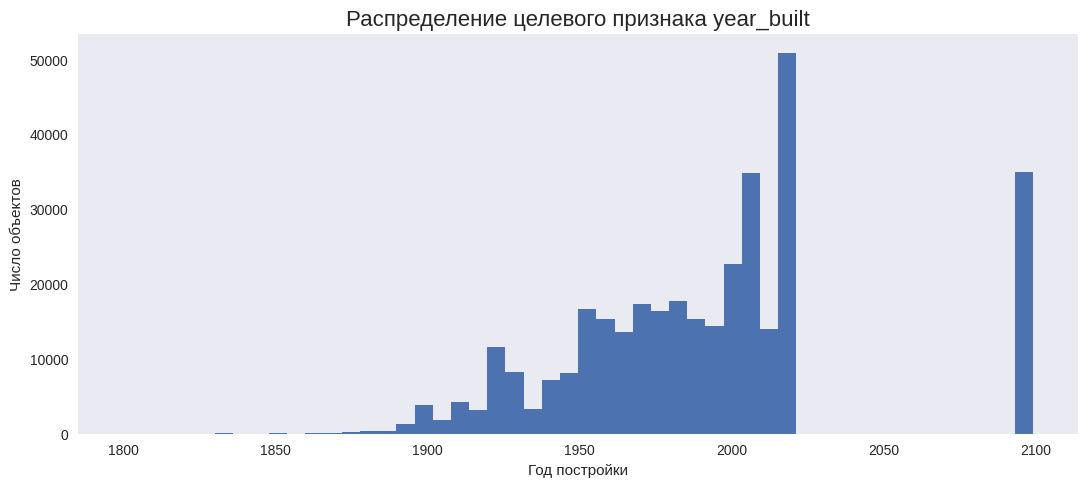

In [59]:
# Построим гистограмму распределения признака year_built
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0,0,1,1])
axes.hist(
    data['year_built'],
    bins=50
)
axes.set_title('Распределение целевого признака year_built', fontsize=16)
axes.set_xlabel('Год постройки')
axes.set_ylabel('Число объектов')
axes.grid();

Видим, что данные распределены не нормально. Единичные объекты датируются XVIII-XIX веками, возможно это реальные дома, но стоит изучить их в разрезе других признаков.

In [60]:
data.year_built.value_counts()

2099    34990
2019    31867
2006     7870
2005     7373
2007     6989
        ...  
1823        1
1811        1
1845        1
1809        1
1804        1
Name: year_built, Length: 209, dtype: int64

### Признак remodeled_year 

Год реконструкции (ремонта) - может иметь значение при оценке недвижимости. Но у нас в нем более половины пропусков, попробуем использовать его и пока не будем удалять.

In [61]:
data['remodeled_year'].value_counts()

        164965
2006      5453
2005      4742
2007      4324
2008      3729
         ...  
1845         1
1853         1
1870         1
1869         1
1862         1
Name: remodeled_year, Length: 150, dtype: int64

In [62]:
# Заполним пустые значения в признаке значением 2099
data.loc[(data['remodeled_year'] == ''), 'remodeled_year'] = 2099
data.loc[(data['remodeled_year'].isnull() == True), 'remodeled_year'] = 2099

# Приведем данные к типу Int
data['remodeled_year'] = data['remodeled_year'].astype(int)

In [63]:
# Заменим явные выбросы временным значением
data.loc[data['remodeled_year'] < 1850, 'remodeled_year'] = 2099

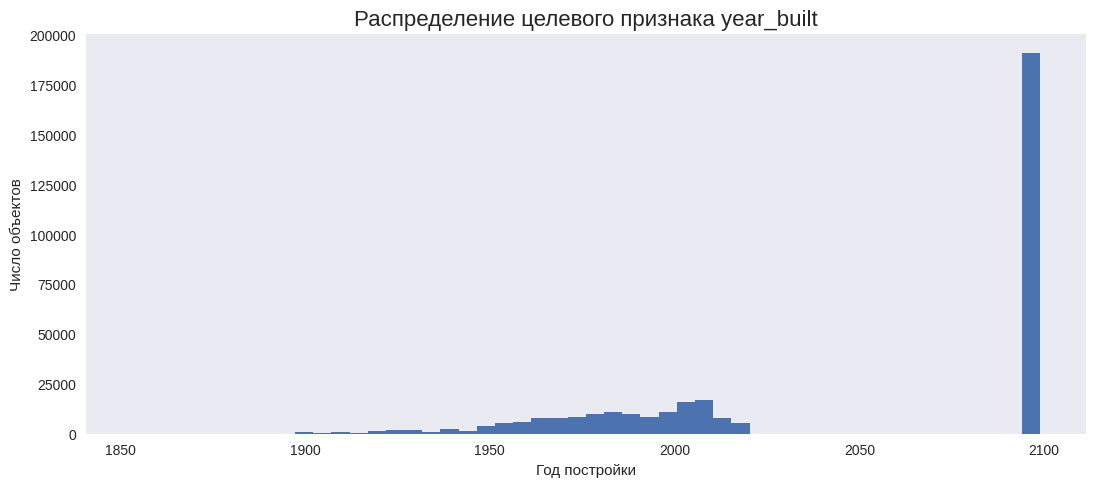

In [64]:
# Построим гистограмму распределения признака
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0,0,1,1])
axes.hist(
    data['remodeled_year'],
    bins=50
)
axes.set_title('Распределение целевого признака year_built', fontsize=16)
axes.set_xlabel('Год постройки')
axes.set_ylabel('Число объектов')
axes.grid();

### Признак beds

Число спален в доме - важный признак для оценки недвижимости, аналог числу комнат в России.

Но признак не простой, тут в нем нет единообразия, кроме спален указывается и площадь дома/участка, число ванных, описание объекта недвижимости и т.п.

In [65]:
# С помощью регулярных выражений вытащим символы, которые указываются в признаке кроме цифр
data['beds_sym'] = data['beds'].apply(lambda x: re.sub("[0-9]", "", str(x)))
data['beds_sym'].unique()

array(['', ' Beds', 'nan', ' bd', 'Baths', '.', 'Bath', '. acres', ' ',
       ', sqft', '-- bd', ' acres', '-- sqft',
       ' Bath,  Bedrooms, Living Room, Range/Oven, Refrigerator', ' sqft',
       ' acre', ' Bath,  Bedrooms',
       "Based on Redfin's St Johns data, we estimate the home's value is $,, which is .% less than its current list price.",
       ' Bath,  Bedrooms, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator',
       ' or More Bedrooms, Dining Room, Living Room, Range/Oven, Refrigerator',
       ' Bath,  or More Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator',
       "Based on Redfin's Raleigh data, we estimate the home's value is $,, which is .% more than its current list price.",
       ' Baths,  or More Bedrooms', ' or More Bedrooms',
       ' Bath,  Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room'],
      dtype=object)

In [66]:
# В ряде объектов в признаке указано и число ванных и число спален, разобьем данные по верным признакам вручную
data.loc[data['beds_sym'] == ' Bath,  Bedrooms, Living Room, Range/Oven, Refrigerator', 'beds'] = 2
data.loc[data['beds_sym'] == ' Bath,  Bedrooms, Living Room, Range/Oven, Refrigerator', 'baths'] = 1
data.loc[data['beds_sym'] == ' Bath,  Bedrooms, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator', 'beds'] = 2
data.loc[data['beds_sym'] == ' Bath,  Bedrooms, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator', 'baths'] = 1
data.loc[data['beds_sym'] == ' or More Bedrooms, Dining Room, Living Room, Range/Oven, Refrigerator', 'beds'] = 3
data.loc[data['beds_sym'] == ' Bath,  or More Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator', 'beds'] = 3
data.loc[data['beds_sym'] == ' Bath,  or More Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator', 'baths'] = 1
data.loc[data['beds_sym'] == ' Baths,  or More Bedrooms', 'beds'] = 3
data.loc[data['beds_sym'] == ' Baths,  or More Bedrooms', 'baths'] = 2
data.loc[data['beds_sym'] == ' or More Bedrooms', 'beds'] = 3
data.loc[data['beds_sym'] == ' Bath,  Bedrooms', 'beds'] = 2
data.loc[data['beds_sym'] == ' Bath,  Bedrooms', 'baths'] = 1
data.loc[data['beds_sym'] == ' Bath,  Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room', 'beds'] = 2
data.loc[data['beds_sym'] == ' Bath,  Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room', 'baths'] = 1
data.loc[data['beds_sym'] == '# Bedrooms st Floor', 'beds'] = 1
data.loc[data['beds_sym'] == "Based on Redfin's St Johns data, we estimate the home's value is $,, which is .% less than its current list price.", 'beds'] = -1
data.loc[data['beds_sym'] == "Based on Redfin's Raleigh data, we estimate the home's value is $,, which is .% more than its current list price.", 'beds'] = -1

In [67]:
# В признаке могут быть указаны не спальни, а площадь объекта (sqft), перенесем значения туда
data.loc[data['beds_sym'] == ', sqft', 'sqft'] = data['beds']
data.loc[data['beds_sym'] == ' sqft', 'sqft'] = data['beds']

data.loc[data['beds_sym'] == ', sqft', 'beds'] = -1
data.loc[data['beds_sym'] == ' sqft', 'beds'] = -1

# В признаке могут быть указаны не спальни, а площадь участка (lotsize), перенесем значения туда
data.loc[data['beds_sym'] == '. acres', 'lotsize'] = data['beds']
data.loc[data['beds_sym'] == ' acres', 'lotsize'] = data['beds']
data.loc[data['beds_sym'] == ' acre', 'lotsize'] = data['beds']

data.loc[data['beds_sym'] == '. acres', 'beds'] = -1
data.loc[data['beds_sym'] == ' acres', 'beds'] = -1
data.loc[data['beds_sym'] == ' acre', 'beds'] = -1

In [68]:
# Избавимся от лишних символов в признаке, значения с NaN и без указания числа спален заполним значением -1
data['beds'] = data['beds'].apply(lambda x: str(x).replace(' Beds','').replace(' bd',''))
data['beds'] = data['beds'].apply(lambda x: str(x).replace('nan','-1').replace('Baths','-1').replace('Bath','-1').replace('-- sqft','-1').replace('--','-1').replace(' ','-1'))

# Приведем данные к типу Int
data['beds'] = data['beds'].apply(pd.to_numeric).astype(int)

# Удалим временный признак beds_sym
data.drop(['beds_sym'], axis=1, inplace=True)

In [69]:
data.beds.describe()

count    338180.000000
mean          2.314055
std           2.215267
min          -1.000000
25%           1.000000
50%           3.000000
75%           4.000000
max         144.000000
Name: beds, dtype: float64

### Признак baths

Число ванных - значимый признак для оценки недвижимости. 

Проанализировав данные пришлось углубиться в тему, чтобы понять, как может быть 0.5 или 0.75 ванной комнаты. В Америке полноценная ванная имеет ванну/душ, раковину, туалет. Если чего то из списка нет в помещении ванной, то соответственно и минусуется четверть, половина...

In [70]:
# С помощью регулярных выражений вытащим символы, которые указываются в признаке кроме цифр
data['baths_sym'] = data['baths'].apply(lambda x: re.sub("[0-9]", "", str(x)))
data['baths_sym'].unique()

array(['.', ' Baths', 'nan', '', 'Bathrooms: ', ',', ' ba', '. Baths',
       '~', '.+', ' / ', 'Sq. Ft. ', '-- baths', '. ba', ',+', '- / - / ',
       '—', ' /  / ', ' baths', 'Bathrooms: SemiMod', '- / -',
       ' /  /  / ', '- / - / - / -', ' / - / - / -'], dtype=object)

In [71]:
# Избавимся от лишних символов в признаке, значения с NaN и без указания числа ванн заполним значением -1
data['baths'] = data['baths'].apply(lambda x: str(x).replace(' Baths','').replace('Bathrooms: ','').replace(' baths','').replace(' ba','').replace('+','').replace(',','.'))
data['baths'] = data['baths'].apply(lambda x: str(x).replace('nan','-1').replace('Sq. Ft. ','-1').replace('~','-1').replace('—','-1').replace('--','-1').replace('SemiMod','-1'))

# Заменим непонятные строки также на -1
data.loc[((data['baths_sym'] == ' / ') | (data['baths_sym'] == '- / - / ') | (data['baths_sym'] == ' /  / ') | (data['baths_sym'] == '- / -') | (data['baths_sym'] == ' /  /  / ') | (data['baths_sym'] == '- / - / - / -') | (data['baths_sym'] == ' / - / - / -')), 'baths'] = -1

# Приведем данные к типу Float
data['baths'] = data['baths'].astype(float)

# Удалим временный признак baths_sym
data.drop(['baths_sym'], axis=1, inplace=True)

In [72]:
# В части наблюдений получилось аномально большое число ванных, а именно 750.  Такие явные выбросы лучше сразу исключить.
data = data.loc[data['baths'] != 750]
data.reset_index(drop=True, inplace=True)

In [73]:
data.baths.describe()

count    337944.000000
mean          1.887493
std           2.002219
min          -1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         241.000000
Name: baths, dtype: float64

### Признак sqft

Площадь объекта недвижимости в кв.футах - важный признак для прогноза его цены. 

In [74]:
# С помощью регулярных выражений вытащим символы, которые указываются в признаке кроме самой площади
data['sqft_sym'] = data['sqft'].apply(lambda x: re.sub("[0-9]", "", str(x)))
data['sqft_sym'].unique()

array(['', ', sqft', ' sqft', ',', 'nan',
       'Total interior livable area: , sqft',
       'Total interior livable area:  sqft', '-- sqft', '--', ',, sqft',
       ',,'], dtype=object)

Видим, что есть варианты в написании площади - разряды чисел могут разделяться запятой, в конце строки может быть сокращение sqft, часть строк имеет в начале пояснение "Total interior livable area".

In [75]:
# Избавимся от лишних символов в признаке, значения с NaN и без указания площади заполним значением -1
data['sqft'] = data['sqft'].apply(lambda x: str(x).replace('Total interior livable area: ','').replace(' sqft','').replace(',',''))
data['sqft'] = data['sqft'].apply(lambda x: str(x).replace('nan','-1').replace('--','-1'))

# Приведем данные к типу Int
data['sqft'] = data['sqft'].astype(int)

# Удалим временный признак sqft_sym
data.drop(['sqft_sym'], axis=1, inplace=True)

In [76]:
data.sqft.value_counts()

-1         21958
 1200       1350
 1500        990
 1000        968
 1800        965
           ...  
 175941        1
 7504          1
 9140          1
 50966         1
 8479          1
Name: sqft, Length: 9297, dtype: int64

### Признак lotsize

Площадь земельного участка - важный признак для прогноза его цены.

In [77]:
# С помощью регулярных выражений вытащим символы, которые указываются в признаке кроме самой площади
data['lotsize_sym'] = data['lotsize'].apply(lambda x: re.sub("[0-9]", "", str(x)))
data['lotsize_sym'].unique()

array(['None', ' sqft', ', sqft', ', Sq. Ft.', '', '. acres',
       ', sqft lot', '. acres lot', '—', 'No Data', '-- sqft lot',
       '. Acres', ' Acre', ' acres', ' Sq. Ft.', ' acre lot', ' sqft lot',
       ' Acres', ' acre', ' acres lot', ',. acres', ', acres',
       ', acres lot', ',. Acres', ',. acres lot', '-'], dtype=object)

Видим, что в данных полный хаос. Площадь участка может указываться в кв.футах или акрах (1 акр = 43560 кв.футов) или единица измерения не указываться вовсе. Кроме того есть явные пропуски (nan) и неявные, как значения "No Data" или "—". 

Попробуем привести данные к единому формату - переведем все в акры.

In [78]:
# Создадим новый признак и заполним его значениями исходного, из которого возьмем только числа и точки
data['lotsize_acres'] = data['lotsize'].apply(lambda x: re.sub("[^0-9\.]", "", str(x)))

# Заполним пропущенные значения числом 999999
data.loc[(data['lotsize_acres'] == ''), 'lotsize_acres'] = 999999

# Удалим лишние символы и приведем данные к типу float
data['lotsize_acres'] = data['lotsize_acres'].apply(lambda x: str(x).replace('..',''))
data['lotsize_acres'] = data['lotsize_acres'].astype(float)

# Переведем кв.футы в акры
sqft_list = [',', ' sqft', ', sqft', ', Sq. Ft.', ', sqft lot', ' Sq. Ft.', ' sqft lot']

for i in sqft_list:
    data.loc[(data['lotsize_sym'] == i), 'lotsize_acres'] /= 43560

Осталось разобраться со значениями, где не указана единица измерения. Так как акр более чем в 40 тысяч раз больше кв.фута, можно условно разделить данные на 2 группы. Если значение маленькое - это акры, если большое - это кв.футы. За границу возьму число 100 - для жилой площади это практически минимум (по данным датасета 25-й квантиль на уровне 1300 кв.футов), для земельного участка это очень много и таких объектов в датасете всего 50.  

In [79]:
data.loc[(data['lotsize_sym'] == '') & (data['lotsize_acres'] > 100) & (data['lotsize_acres'] != 999999), 'lotsize_acres'] /= 43560

In [80]:
# Удалим временный признак lotsize_sym и исходный признак
data.drop(['lotsize_sym', 'lotsize'], axis=1, inplace=True)

In [81]:
data.lotsize_acres.value_counts()

999999.000000    90829
0.260000          3063
0.250000          2873
0.280000          2604
0.139991          2547
                 ...  
4.780005             1
0.062213             1
0.051676             1
35.671993            1
0.065909             1
Name: lotsize_acres, Length: 16318, dtype: int64

### Признак stories

Число этажей в здании - важный признак для прогноза его цены.

In [82]:
# Так как очень много уникальных значений, сперва приведем все к нижнему регистру
data['stories'] = data['stories'].apply(lambda x: str(x).lower())

In [83]:
data.stories.value_counts()

nan                                           117605
1.0                                            64881
2.0                                            54095
1                                              22653
2                                              17811
                                               ...  
sixplex                                            1
townhouse-2 story, t3-townhouse 3+ stories         1
multi-level, new englander                         1
4.0000                                             1
50.0                                               1
Name: stories, Length: 337, dtype: int64

Видим, что в признаке может быть и числовая и буквеная запись числа этажей, кроме того может быть и другая информация о доме.

In [84]:
# Заменим на числа соответствующие им слова в признаке
data['stories'] = data['stories'].apply(lambda x: 1 if 'one' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 3 if ('tri' in str(x) or 'three' in str(x)) else x)
data['stories'] = data['stories'].apply(lambda x: 2 if ('two' in str(x) or 'bi-' in str(x) or 'double' in str(x)) else x)

# С помощью регулярных выражений оставим в признаке только числа и точки
data['stories'] = data['stories'].apply(lambda x: re.sub("[^0-9\.]", "", str(x)))

# Заполним пустые значения, исправим некорректные символы 
data.loc[data['stories'] == '', 'stories'] = 999999
data['stories'] = data['stories'].apply(lambda x: str(x).replace('....',''))


In [85]:
# Приведем данные в числовой вид и округлим до целого
data['stories'] = data['stories'].apply(pd.to_numeric).apply(lambda x: round(x, 0))

In [86]:
# Преобразуем значения в признаке к категориальному формату
data.loc[(data['stories'] > 3) & (data['stories'] != 999999), 'stories'] = 'multi'
data.loc[(data['stories'] == 999999) | (data['stories'] == 0.0), 'stories'] = 'unknown'
data.loc[data['stories'] == 1, 'stories'] = 'one'
data.loc[data['stories'] == 2, 'stories'] = 'two'
data.loc[data['stories'] == 3, 'stories'] = 'tri'

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337944 entries, 0 to 337943
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              337944 non-null  object 
 1   street              337944 non-null  object 
 2   baths               337944 non-null  float64
 3   fireplace           337944 non-null  int64  
 4   city                337935 non-null  object 
 5   schools             337944 non-null  object 
 6   sqft                337944 non-null  int64  
 7   zipcode             337944 non-null  object 
 8   beds                337944 non-null  int64  
 9   state               337944 non-null  object 
 10  stories             337944 non-null  object 
 11  target              337944 non-null  int64  
 12  year_built          337944 non-null  int64  
 13  remodeled_year      337944 non-null  int64  
 14  heating             337944 non-null  int64  
 15  cooling             337944 non-nul

### Признак school

Признак schools внутри себя содержит словарь с информацией о школах в окресностях объектов недвижимости - списки с названиями, уровнями и рейтингами ближайших школ, а также с расстоянием до них.

Название школы никакой полезной информации для модели не даст, использовать данный признак не будем.

Уровень школы - очень неоднозначный признак для подачи в модель. В Америке школы, как правило, делят на три уровня по возрастам: еlementary (0-5 класс), middle (6-8 класс) и high school (9-12 класс). По идее, школы разного уровня - это независимые отдельные здания, которые территориально могут находиться в разных местах района/города.

Если обрабатывать данный признак, то можно было бы на его основе создать три новых бинарных призака по уровню школ (есть или нет школа определенного уровня поблизости). Но я считаю, что так углубляться не стоит, и уровни школ не могут существенно повлиять на цену недвижимости. Поэтому использовать данный признак не будем.

С другой стороны, сам факт наличия школы поблизости может иметь значение при оценке стоимости недвижимости. А рейтинг ближайших школ может дать косвенное представление о благополучии района, в котором находится недвижимость.

Поэтому распакуем словарь и вынесем в отдельные признаки рейтинг школ и расстояние до них.

In [88]:
# Сперва преобразуем строку в словарь 
data.schools = data.schools.apply(lambda x: eval(x[1:-1]))

# Извлекаем значения из словаря и создаем из них новые признаки в датасете\
data['s_rating'] = data['schools'].apply(lambda x: x.get('rating'))
data['s_distance'] = data['schools'].apply(lambda x: x.get('data').get('Distance'))

Признак **s_rating** содержит список с рейтингами ближайших школ. Длина списка не фиксированная,то есть число школ может быть любым. Лучше всего вычислить средний рейтинг школ в районе рядом с объектом недвижимости и использовать в модели только его.

In [89]:
# Напишем функцию для расчета среднего рейтинга школ
def rating_mean(ratings):
    rating_list = []
    for i in ratings:
        if i.isdigit() is True and i != 0:
            rating_list.append(int(i))
        elif '/10' in i and 'None' not in i:
            rating_list.append(int(i[:-3]))
    return round(np.average(rating_list), 1)

In [90]:
# Создадим новый признак используя функцию
data['school_rating'] = (data['s_rating']).apply(rating_mean)

In [91]:
data.school_rating.describe()

count    334056.000000
mean          5.193887
std           1.943830
min           1.000000
25%           3.700000
50%           5.200000
75%           6.600000
max          10.000000
Name: school_rating, dtype: float64

Признак **s_distance** содержит список с расстояниями до ближайших школ. Длина списка не фиксированная,так как число школ может быть любым. Думаю, что из данного признака лучше всего взять два значения - расстояние до ближайшей школы и среднее расстояние до школ из списка.

In [92]:
# Напишем функции для расчета минимального и среднего расстояния до школ
def distance_min(distance):
    distance_list = []
    for i in distance:
        distance_list.append(float(i.replace('mi','').replace(' ','')))
    if distance_list == []:
        return np.nan
    else:
        return round(np.min(distance_list), 2)
    
def distance_mean(distance):
    distance_list = []
    for i in distance:
        distance_list.append(float(i.replace('mi','').replace(' ','')))
    return round(np.average(distance_list), 2)

In [93]:
# Создадим новые признаки используя функцию
data['school_min_distance'] = (data['s_distance']).apply(distance_min)
data['school_mean_distance'] = (data['s_distance']).apply(distance_mean)

In [94]:
# Удалим исходный и временные признаки
data.drop(['schools', 's_distance', 's_rating'], axis=1, inplace=True)

In [95]:
data.describe()

baths      fireplace          sqft           beds  \
count  337944.000000  337944.000000  3.379440e+05  337944.000000   
mean        1.887493       0.290403  6.255925e+03       2.316369   
std         2.002219       0.453949  1.578581e+06       2.214308   
min        -1.000000       0.000000 -1.000000e+00      -1.000000   
25%         1.000000       0.000000  1.200000e+03       1.000000   
50%         2.000000       0.000000  1.766000e+03       3.000000   
75%         3.000000       1.000000  2.550000e+03       4.000000   
max       241.000000       1.000000  7.959794e+08     144.000000   

             target     year_built  remodeled_year        heating  \
count  3.379440e+05  337944.000000   337944.000000  337944.000000   
mean   5.900029e+05    1992.229372     2048.548579       0.734136   
std    8.800650e+05      48.055650       59.809088       0.441793   
min    9.850000e+03    1800.000000     1853.000000       0.000000   
25%    2.100000e+05    1961.000000     1992.000000       0.000000   
50%    3.399000e+05    1993.000000     2099.000000       1.000000   
75%    5.990000e+05    2016.000000     2099.000000       1.000000   
max    1.000000e+07    2099.000000     2099.000000       1.000000   

             cooling        parking   private_pool  lotsize_acres  \
count  337944.000000  337944.000000  337944.000000  337944.000000   
mean        0.683279       0.510401       0.127787  268770.746057   
std         0.465198       0.499893       0.333853  443318.991171   
min         0.000000       0.000000       0.000000       0.000023   
25%         0.000000       0.000000       0.000000       0.139991   
50%         1.000000       1.000000       0.000000       0.248485   
75%         1.000000       1.000000       0.000000  999999.000000   
max         1.000000       1.000000       1.000000  999999.000000   

       school_rating  school_min_distance  school_mean_distance  
count  334056.000000        334864.000000         334864.000000  
mean        5.193887             1.109122              2.770441  
std         1.943830             5.584600              6.106785  
min         1.000000             0.000000              0.000000  
25%         3.700000             0.340000              1.030000  
50%         5.200000             0.630000              1.700000  
75%         6.600000             1.200000              3.080000  
max        10.000000          1590.380000           1590.830000

### Признаки state, city, street, zipcode

Продуманное использование географических данных в работе смогло бы значительно повысить эффективность модели. Но для этого потребуется целый комплекс дополнительных инструментов и данных из внешних источников.

Алгоритм примерно такой:
1. Агрегируем имеющиеся данные (штат, город, улица, zipcode) и с помощью дополнительных библиотек находим геометки для объектов недвижимости в базе - широту и долготу.
2. Ищем, подгружаем, данные из внешних источников с данными по городам США (в идеале по районам, улицам): численность населения, уровень жизни, заработная плата, уровень преступности, благоустройство, транспортная доступность, расположение объектов культуры, досуга, медицины и т.д.
3. Делаем предобработку внешних данных и дополняем ими исходный датасет.
4. Затем нужно соотнести статистические данные со штатами и городами, имеющимися в датасете, подготовить новые признаки. По имеющимся геоданным также требуется построить связи с координатами объектов недвижимости в датасете.

В рамках данного проекта такой объем работы выполнить не представляется возможным, поэтому географические признаки придется использовать по минимуму.

**State** - названия штатов (39 уникальных значений) самый общий из имеющихся географических признаков. Средние цены на недвижимость в разных штатах могут отличаться, но опять же конкретные объекты оцениваются индивидуально. По штатам удобно агрегировать объекты в разрезе других признаков, поэтому признак оставим.

В признаке нет пропусков и его предобработка почти не требуется.

In [96]:
# Посмотрим на штаты, где меньше всего объектов
data.state.value_counts()[25:]

WI    416
IA    211
ME    183
KY     75
OK     30
SC     27
MS     26
DE      5
MT      3
Fl      1
BA      1
OT      1
OS      1
Name: state, dtype: int64

In [97]:
# Штат Fl видимо ошибка, исправим на FL
data.loc[data['state'] == 'Fl', 'state'] = 'FL'

# Штаты, в которых менее 100 объектов на продажу, исключим как малоинформативные
state_list = ['KY', 'OK', 'SC', 'MS', 'DE', 'MT', 'BA', 'OT', 'OS']
for i in state_list:
    data = data[data['state'] != i]

data.reset_index(drop=True, inplace=True)

**ZipCode** на мой взгляд, самый полный из имеющихся признаков - это аналог почтового индекса в США (около 4500 уникальных значений). Он агрегирует в себе и название штата и город и определенный район обслуживания (набор улиц). Он наиболее точно может отразить среднюю цену недвижимости в данном районе.

In [98]:
# Приведем признак zipcode к единому формату: оставим только пятизначные цифры, пропуски заменим на -1
data['zipcode'] = data['zipcode'].apply(lambda x: re.sub('\D', '', str(x)))
data['zipcode'] = data['zipcode'].apply(lambda x: -1 if (len(x) < 3 or x == '') else x)
data['zipcode'] = data['zipcode'].apply(lambda x: x[:5] if len(str(x)) > 5 else x)

In [99]:
# Посмотрим на пропуски
data[data['zipcode'] == -1]

status                     street  baths  fireplace             city  \
74849       new  Cornejo Ricardo Descalzi    -1.0          0    Quito Ecuador   
210690  unknown    1744 N Dixie Hwy # 1744    3.0          0  Fort Lauderdale   

        sqft zipcode  beds state  stories  ...  parking  property_main_type  \
74849     -1      -1    -1    NY  unknown  ...        0                 NaN   
210690  2043      -1     3    FL  unknown  ...        0           townhouse   

        property_add_type  property_style  property_story  private_pool  \
74849                 NaN        colonial             NaN             0   
210690           attached             NaN             two             0   

       lotsize_acres school_rating school_min_distance school_mean_distance  
74849       999999.0           NaN                 NaN                  NaN  
210690      999999.0           5.0                 0.5                  0.6  

[2 rows x 25 columns]

Объекты без индекса можно поправить вручную. Первая запись явный выброс (указан город Кито, Эквадор, в данных одни пропуски), удалим эту строку. Другой индекс найду по городу и улице в интернете.

In [100]:
# Удалим выброс
data.drop(data[data['zipcode'] == -1].index[0], inplace=True)

# Заменим zipcode на корректный
data.at[data[data['zipcode'] == -1].index[0], 'zipcode'] = 33305


In [101]:
# Приведем признак к типу данных int, сбросим индексы
data['zipcode'] = data['zipcode'].apply(pd.to_numeric)
data.reset_index(drop=True, inplace=True)

**Street** - названия улицы (более 300 тыс уникальных значений) для модели нам никакой дополнительной информации не даст, тем более что в разных городах многие названия улиц повторяются.

**City** - названия городов (1900 уникальных значений) более содердательный признак, но стоит учитывать, что в любом городе есть богатые и бедные районы, поэтому и цены на кв.фут недвижимости могут колебаться внутри города в разы.

Оба признака удалю.

In [102]:
# Удалим неинформативные географические признаки
data.drop(['city', 'street'], axis=1, inplace=True)

## Очистка данных

На данном этапе нужно корректно заполнить пропуски в данных, избавиться от дублейб проанализировать все признаки на наличие выбросов и аномальных значений. Изучим распределение признаков и их взаимосвязи с другими признаками.

### Поиск дублей и пропусков в данных

In [103]:
# Проверим, есть ли дубли в данных
data.duplicated().sum()

2094

In [104]:
# Удалим дубли
data = data.drop_duplicates(ignore_index=True)
data.duplicated().sum()

0

In [105]:
# Заменим на nan значения, которые мы временно присваивали пропускам в данных
data['status'] = data['status'].replace('unknown', np.nan)
data['year_built'] = data['year_built'].replace(2099, np.nan)
data['remodeled_year'] = data['remodeled_year'].replace(2099, np.nan)
data['beds'] = data['beds'].replace(-1, np.nan)
data['baths'] = data['baths'].replace(-1, np.nan)
data['sqft'] = data['sqft'].replace(-1, np.nan)
data['lotsize_acres'] = data['lotsize_acres'].replace(999999, np.nan)
data['stories'] = data['stories'].replace('unknown', np.nan)

Объединим записи из признаков stories и property_story в один. При этом основным будем считать признак stories и дополнять пропуски будем в нем.

In [106]:
# Объединим записи о числе этажей из двух признаков в один
data.loc[data['stories'] == 'one', 'property_story'] = 'one'
data.loc[data['stories'] == 'two', 'property_story'] = 'two'
data.loc[data['stories'] == 'tri', 'property_story'] = 'tri'
data.loc[data['stories'] == 'multi', 'property_story'] = 'multi'

# Удалим дублирующий признак
data['stories'] = data['property_story']
data = data.drop(['property_story'], axis = 1)

In [107]:
# Посмотрим на реальную картину пропусков в данных (в процентах)
data.isna().sum().sort_values(ascending=False) / len(data) * 100

property_style          94.545996
remodeled_year          56.282173
lotsize_acres           26.619995
stories                 23.629349
beds                    23.614454
baths                   22.756792
property_add_type       15.559461
property_main_type      15.531756
status                  11.535987
year_built              10.171890
sqft                     6.434104
school_rating            1.125775
school_min_distance      0.886559
school_mean_distance     0.886559
parking                  0.000000
cooling                  0.000000
target                   0.000000
private_pool             0.000000
state                    0.000000
zipcode                  0.000000
fireplace                0.000000
heating                  0.000000
dtype: float64

Признаки sqft, beds, baths, stories, property_main_type и year_built считаю одними из важнейших в оценке стоимости недвижимости. Если есть объекты с пропусками во всех этих признаках, то качественного прогноза по ним сделать не получится. 

Проверим сколько таких объектов в датасете. 

In [108]:
data[
    (data['sqft'].isnull() == True)
    & (data['beds'].isnull() == True)
    & (data['baths'].isnull() == True)
    & (data['stories'].isnull() == True) 
    & (data['year_built'].isnull() == True)
    & (data['property_main_type'].isnull() == True)    
    ]

status  baths  fireplace  sqft  zipcode  beds state stories  target  \
39      active    NaN          0   NaN    33947   NaN    FL     NaN   54000   
40      active    NaN          0   NaN    10006   NaN    NY     NaN  850000   
46      active    NaN          0   NaN    37377   NaN    TN     NaN  125000   
58      active    NaN          0   NaN    77327   NaN    TX     NaN   50000   
79      active    NaN          0   NaN    32219   NaN    FL     NaN   18000   
...        ...    ...        ...   ...      ...   ...   ...     ...     ...   
335545  active    NaN          0   NaN    75216   NaN    TX     NaN  125000   
335607  active    NaN          0   NaN    33953   NaN    FL     NaN   15000   
335620  active    NaN          0   NaN    33133   NaN    FL     NaN  639000   
335637  active    NaN          0   NaN    32836   NaN    FL     NaN  400000   
335650  active    NaN          0   NaN    28216   NaN    NC     NaN   99990   

        year_built  ...  cooling  parking  property_main_type  \
39             NaN  ...        0        0                 NaN   
40             NaN  ...        0        0                 NaN   
46             NaN  ...        0        0                 NaN   
58             NaN  ...        0        0                 NaN   
79             NaN  ...        0        0                 NaN   
...            ...  ...      ...      ...                 ...   
335545         NaN  ...        0        0                 NaN   
335607         NaN  ...        0        0                 NaN   
335620         NaN  ...        0        0                 NaN   
335637         NaN  ...        0        0                 NaN   
335650         NaN  ...        0        0                 NaN   

        property_add_type property_style private_pool lotsize_acres  \
39                    NaN            NaN            0           NaN   
40                    NaN            NaN            0           NaN   
46                    NaN            NaN            0           NaN   
58                    NaN            NaN            0           NaN   
79                    NaN            NaN            0      2.590000   
...                   ...            ...          ...           ...   
335545                NaN            NaN            0      1.010000   
335607                NaN            NaN            0      0.229568   
335620                NaN            NaN            0      0.330000   
335637                NaN            NaN            0           NaN   
335650                NaN            NaN            0      0.160009   

        school_rating  school_min_distance  school_mean_distance  
39                6.3                  3.1                  3.97  
40                7.0                  0.1                  2.36  
46                6.3                  3.9                  5.45  
58                4.2                 11.3                 12.18  
79                4.3                  3.5                  6.60  
...               ...                  ...                   ...  
335545            4.8                  0.3                  2.12  
335607            5.0                  5.8                  6.97  
335620            6.8                  0.8                  3.48  
335637            6.7                  1.3                  5.26  
335650            2.7                  0.7                  1.73  

[12629 rows x 22 columns]

Действительно, кроме цены, зипкода, данных по школам и площади участка в некоторых из них, взять из таких объектов нечего - во всех остальных данных пропуски и нули. И хотя таких объектов довольно много, считаю, что лучше будет эти данные из датасета удалить. 

In [109]:
data = data[
    (data['sqft'].isnull() == False)
    | (data['beds'].isnull() == False)
    | (data['baths'].isnull() == False)
    | (data['stories'].isnull() == False)
    | (data['year_built'].isnull() == False)
    | (data['property_main_type'].isnull() == False)
    ]

data.reset_index(drop=True, inplace=True)

### Признак status

Что касается пропусков, пердположу, что если бы объект недвижимости продавался с какими-то дополнительными условиями (контракт, аукцион и т.п.), то в данном признаке была бы соответствующая отметка. Раз отметки не проставили, то такие лоты можно отнести к активным. Поэтому пропуски заполню значением "active".

In [110]:
data.loc[(data['status'].isnull() == True), 'status'] = 'active'

### Признаки school_rating, school_min_distance, school_mean_distance

В данных о школах пропусков не более 1%, поэтому можем себе позволить заполнить их медианными значениями по этим признакам.

In [111]:
data.loc[(data['school_rating'].isnull() == True), 'school_rating'] = data['school_rating'].median()
data.loc[(data['school_min_distance'].isnull() == True), 'school_min_distance'] = data['school_min_distance'].median()
data.loc[(data['school_mean_distance'].isnull() == True), 'school_mean_distance'] = data['school_mean_distance'].median()

In [112]:
data.describe()

baths      fireplace          sqft        zipcode  \
count  259290.000000  323051.000000  3.140820e+05  323051.000000   
mean        2.741233       0.302980  5.264590e+03   52690.775481   
std         1.417247       0.459547  1.420372e+06   26864.694527   
min         0.000000       0.000000  0.000000e+00    1103.000000   
25%         2.000000       0.000000  1.300000e+03   33025.000000   
50%         2.500000       0.000000  1.845000e+03   37405.000000   
75%         3.000000       1.000000  2.629000e+03   77845.000000   
max       241.000000       1.000000  7.959794e+08   99338.000000   

                beds        target     year_built  remodeled_year  \
count  256411.000000  3.230510e+05  301535.000000   145808.000000   
mean        3.347766  5.720561e+05    1979.775154     1983.115769   
std         1.398334  8.318647e+05      33.265744       24.633202   
min         0.000000  9.900000e+03    1800.000000     1853.000000   
25%         3.000000  2.149000e+05    1957.000000     1969.000000   
50%         3.000000  3.390000e+05    1985.000000     1987.000000   
75%         4.000000  5.900000e+05    2007.000000     2004.000000   
max       144.000000  1.000000e+07    2022.000000     2021.000000   

             heating        cooling        parking   private_pool  \
count  323051.000000  323051.000000  323051.000000  323051.000000   
mean        0.764492       0.711423       0.532096       0.133338   
std         0.424316       0.453101       0.498970       0.339940   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       0.000000       0.000000   
50%         1.000000       1.000000       1.000000       0.000000   
75%         1.000000       1.000000       1.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       lotsize_acres  school_rating  school_min_distance  school_mean_distance  
count  240115.000000  323051.000000        323051.000000         323051.000000  
mean        2.221544       5.174714             1.095565              2.769443  
std       149.739171       1.927957             5.654264              6.178048  
min         0.000023       1.000000             0.000000              0.020000  
25%         0.114991       3.700000             0.360000              1.030000  
50%         0.179063       5.000000             0.630000              1.710000  
75%         0.290000       6.500000             1.200000              3.060000  
max     49299.440000      10.000000          1590.380000           1590.830000

Данные в признаке **рейтинга школ** выглядят нормальными, без аномалий. Посмотрим на распределение признака.

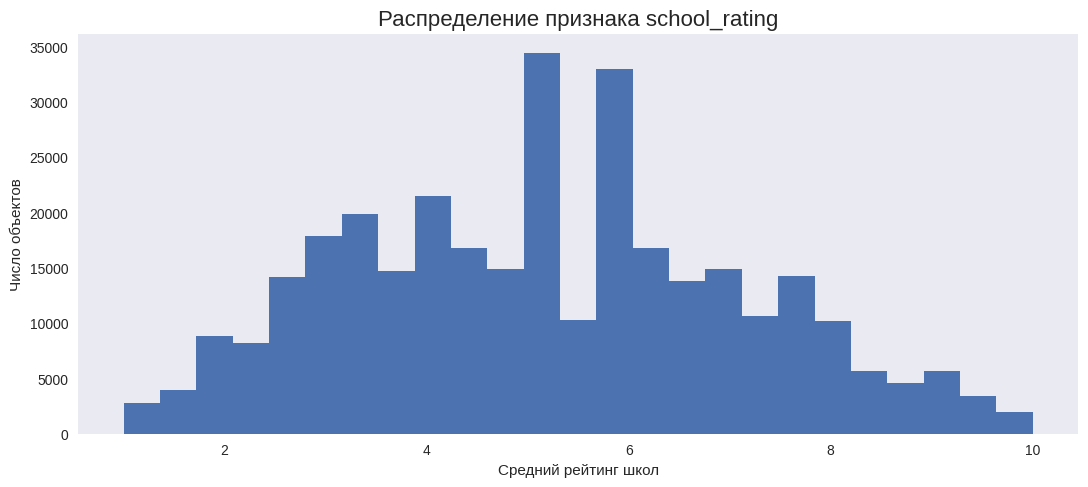

In [113]:
# Построим гистограмму распределения признака school_rating
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0,0,1,1])
axes.hist(
    data['school_rating'],
    bins=25
)
axes.set_title('Распределение признака school_rating', fontsize=16)
axes.set_xlabel('Средний рейтинг школ')
axes.set_ylabel('Число объектов')
axes.grid();

Посмотрим на аномалии в признаках **расстояния до школ**, там максимальные значения достигают 1590 миль.

In [114]:
# Судя по данным, аномальными выглядят значения более 30 миль (расстояние большое, а таких объектов крайне мало)
data.loc[data['school_min_distance'] > 30]

status  baths  fireplace    sqft  zipcode  beds state stories  target  \
637     active    3.0          0  1892.0    79938   4.0    TX     NaN  217580   
642     active    2.0          0  1637.0    79938   4.0    TX     NaN  185950   
3484    active    3.0          0  2184.0    79938   4.0    TX     NaN  273000   
5517    active    2.0          0  1448.0    79938   3.0    TX     NaN  161450   
8981    active    2.0          0  1406.0    79938   4.0    TX     NaN  167950   
...        ...    ...        ...     ...      ...   ...   ...     ...     ...   
319875  active    2.0          0  1504.0    79938   4.0    TX     NaN  177950   
320617  active    3.0          1  2350.0    79938   4.0    TX     NaN  307850   
321685  active    2.0          0  1415.0    79938   3.0    TX     NaN  166450   
321708  active    2.5          0  2155.0    79938   3.0    TX     two  221180   
322365  active    2.0          0  1308.0    79938   4.0    TX     NaN  158950   

        year_built  ...  cooling  parking  property_main_type  \
637         2019.0  ...        0        0  single family home   
642         2019.0  ...        0        0  single family home   
3484        2019.0  ...        0        0  single family home   
5517        2019.0  ...        0        0  single family home   
8981        2019.0  ...        0        0  single family home   
...            ...  ...      ...      ...                 ...   
319875         NaN  ...        1        0  single family home   
320617      2019.0  ...        1        1  single family home   
321685      2019.0  ...        0        0  single family home   
321708         NaN  ...        0        0  single family home   
322365         NaN  ...        0        0  single family home   

        property_add_type property_style private_pool lotsize_acres  \
637              detached            NaN            0      0.050000   
642              detached            NaN            0      0.121694   
3484             detached            NaN            0      0.139991   
5517             detached            NaN            0      0.129982   
8981             detached            NaN            0      0.119995   
...                   ...            ...          ...           ...   
319875           detached            NaN            0      0.139991   
320617           detached            NaN            0      0.053949   
321685           detached            NaN            0      0.100000   
321708           detached            NaN            0           NaN   
322365           detached            NaN            0           NaN   

        school_rating  school_min_distance  school_mean_distance  
637               5.0                39.69                 39.69  
642               5.0                39.69                 39.69  
3484              5.0                39.69                 39.69  
5517              5.0                39.69                 39.69  
8981              5.0                39.69                 39.69  
...               ...                  ...                   ...  
319875            5.0                39.69                 39.69  
320617            5.0                39.69                 39.69  
321685            5.0                39.69                 39.69  
321708            5.0                39.69                 39.69  
322365            5.0                39.69                 39.69  

[198 rows x 22 columns]

In [115]:
# Большинство школ, относящихся к зипкоду 79938, находятся на минимальном расстоянии более 36 миль, но не все. Заменим аномалию медианой по данному зипкоду.
distance_median = np.median(data.loc[(data['school_min_distance'] < 36) & (data['zipcode'] == 79938), 'school_min_distance'])
data.loc[(data['school_min_distance'] > 36) & (data['zipcode'] == 79938), 'school_min_distance'] = distance_median

# Оставшиеся единичные аномальные значения заменим медианой по признаку вцелом
distance_median = np.median(data.loc[data['school_min_distance'] < 30, 'school_min_distance'])
data.loc[data['school_min_distance'] > 30, 'school_min_distance'] = distance_median

In [116]:
# Аналогично обработаем признак school_mean_distance, так как значения в нем практически идентичные
distance_median = np.median(data.loc[(data['school_mean_distance'] < 36) & (data['zipcode'] == 79938), 'school_mean_distance'])
data.loc[(data['school_mean_distance'] > 36) & (data['zipcode'] == 79938), 'school_mean_distance'] = distance_median

distance_median = np.median(data.loc[data['school_mean_distance'] < 30, 'school_mean_distance'])
data.loc[data['school_mean_distance'] > 30, 'school_mean_distance'] = distance_median

In [117]:
# Расстояние до школы не может быть и нулевым, заменим такие записи на ближайшее к нулю значение
data.loc[data['school_min_distance'] < 0.02, 'school_min_distance'] = 0.02

### Признаки property_main_type и property_add_type

In [118]:
# Посмотрим на пропуски 
data[['property_main_type', 'property_add_type']].isna().sum().sort_values(ascending=False)

property_add_type     39602
property_main_type    39508
dtype: int64

Чтобы заполнить пропуски я попробовал найти связь типа недвижимости с другими признаками. Считаю, что лучше всего это прослеживается в разрезе зипкодов. То есть объекты, относящиеся к одному зипкоду, находятся рядом территориально и с большой вероятностью являются типовыми (в городе это квартиры, в сельской местности - частные дома, ранчо).

In [119]:
# Заполним пропуски в признаке property_add_type, взяв самые популярные типы недвижимости по каждому зипкоду 
zipcode_list = list(data.zipcode.unique())
for value in zipcode_list:
    types_list = data.loc[(data['zipcode'] == value), 'property_add_type']
    if len(types_list.unique()) == 1 and types_list.unique()[0] is np.nan:
        pass
    else:
        data.loc[(data['zipcode'] == value) & (data['property_add_type'].isnull() == True), 'property_add_type'] = types_list.mode()[0]

In [120]:
# Оставшиеся пропуски (менее 100 объектов) заполним модой по соответствующему объекту штату
state_list = list(data.state.unique())
for value in state_list:
    types_list = data.loc[(data['state'] == value), 'property_add_type']
    data.loc[(data['state'] == value) & (data['property_add_type'].isnull() == True), 'property_add_type'] = types_list.mode()[0]

Пропуски в признаке property_main_type легко заполнить обобщив категории из признака property_add_type.

In [121]:
for value in ['carriage', 'cottage','custom', 'detached', 'log', 'ranch', 'split']:
    data.loc[(data['property_main_type'].isnull() == True) & (data['property_add_type'] == value), 'property_main_type'] = 'single family home'

data.loc[(data['property_main_type'].isnull() == True) & (data['property_add_type'] == 'attached'), 'property_main_type'] = 'townhouse'
data.loc[(data['property_main_type'].isnull() == True) & (data['property_add_type'] == 'patio'), 'property_main_type'] = 'townhouse'
data.loc[(data['property_main_type'].isnull() == True) & (data['property_add_type'] == 'co op'), 'property_main_type'] = 'multi family home'
data.loc[(data['property_main_type'].isnull() == True) & (data['property_add_type'] == 'condo'), 'property_main_type'] = 'multi family home'
data.loc[(data['property_main_type'].isnull() == True) & (data['property_add_type'] == 'mobile'), 'property_main_type'] = 'mobile home'

In [122]:
# Посмотрим, соответствуют ли категории и подкатегории типам недвижимости
data.groupby(by=['property_main_type'])['property_add_type'].value_counts()

property_main_type  property_add_type
mobile home         mobile                 3522
multi family home   condo                 71100
                    co op                  3806
                    detached                 85
                    mobile                   15
                    split                     9
single family home  detached             219667
                    ranch                  3270
                    cottage                1193
                    split                   516
                    custom                  337
                    condo                   129
                    patio                    97
                    mobile                   54
                    attached                 47
                    carriage                 30
                    log                      20
townhouse           attached              18935
                    patio                   174
                    condo                    45
Na

In [123]:
# Исправим пересортицу в данных
data.loc[(data['property_main_type'] == 'multi family home') & (data['property_add_type'] == 'mobile'), 'property_main_type'] = 'mobile home'
data.loc[(data['property_main_type'] == 'multi family home') & (data['property_add_type'] == 'split'), 'property_add_type'] = 'condo'
data.loc[(data['property_main_type'] == 'multi family home') & (data['property_add_type'] == 'detached'), 'property_main_type'] = 'townhouse'
data.loc[(data['property_main_type'] == 'single family home') & (data['property_add_type'] == 'mobile'), 'property_main_type'] = 'mobile home'
data.loc[(data['property_main_type'] == 'single family home') & (data['property_add_type'] == 'condo'), 'property_main_type'] = 'townhouse'
data.loc[(data['property_main_type'] == 'single family home') & (data['property_add_type'] == 'patio'), 'property_main_type'] = 'townhouse'
data.loc[(data['property_main_type'] == 'single family home') & (data['property_add_type'] == 'attached'), 'property_main_type'] = 'townhouse'
data.loc[(data['property_main_type'] == 'townhouse') & (data['property_add_type'] == 'condo'), 'property_add_type'] = 'attached'
data.loc[(data['property_main_type'] == 'townhouse') & (data['property_add_type'] == 'detached'), 'property_add_type'] = 'patio'

### Признак sqft

In [124]:
data.sqft.describe()

count    3.140820e+05
mean     5.264590e+03
std      1.420372e+06
min      0.000000e+00
25%      1.300000e+03
50%      1.845000e+03
75%      2.629000e+03
max      7.959794e+08
Name: sqft, dtype: float64

В признаке осталось около 3% пропусков, а также видны аномальные значения, когда площадь равна нулю или составляет какие-то астрономические числа. Заменим такие значения на nan.

In [125]:
data.loc[(data['sqft'] > 10000000) | (data['sqft'] < 10), 'sqft'] = np.nan

In [126]:
# Заполним пропуски медианной жилплощадью по каждому типу недвижимости для каждого штата
data['sqft'] = data.groupby(['state', 'property_add_type'])['sqft'].transform(lambda x: x.fillna(x.median()))

# Оставшиеся единичные пропуски заполним медианной по типам недвижимости
data['sqft'] = data.groupby(['property_add_type'])['sqft'].transform(lambda x: x.fillna(x.median()))

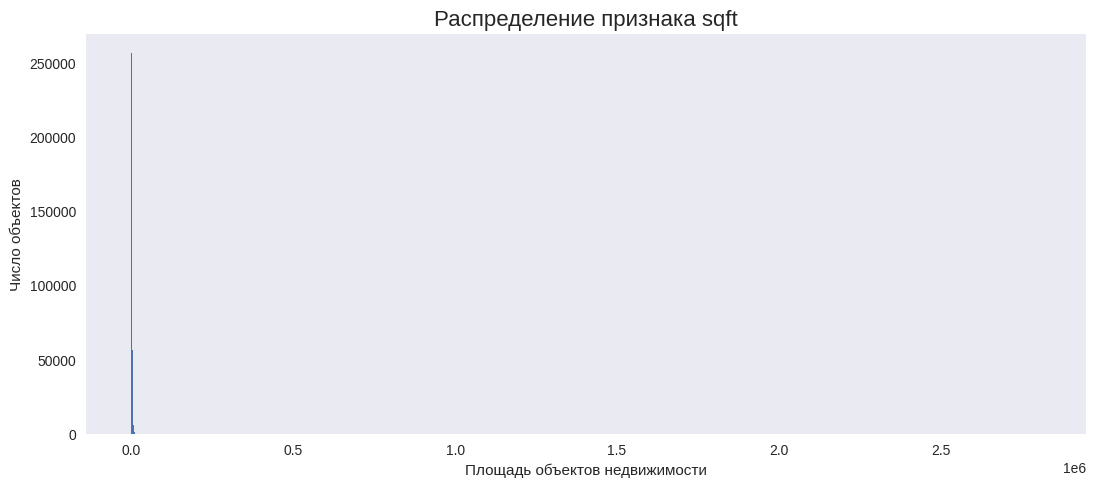

In [127]:
# Построим гистограмму распределения признака 
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0,0,1,1])
axes.hist(
    data['sqft'],
    bins=1000
)
axes.set_title('Распределение признака sqft', fontsize=16)
axes.set_xlabel('Площадь объектов недвижимости')
axes.set_ylabel('Число объектов')
axes.grid();

Из-за очень большого разброса значений график почти нечитабельный. Предположу, что распределение не нормально, а строится экспоненциально с очень длинным хвостом вправо. При этом 75% объектов имеет жилплощадь до 2600 кв.футов.

Воспользуемся методом z отклонений для поиска выбросов. Для этого сперва посмотрим на распределение логарифмированного признака.

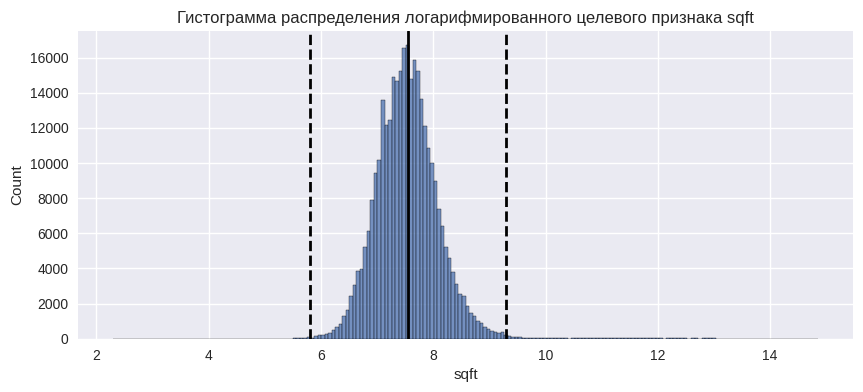

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
log_sqft = np.log(data['sqft'])
histplot = sns.histplot(log_sqft, bins=200, ax=ax)
histplot.axvline(log_sqft.mean(), color='k', lw=2)
histplot.axvline(log_sqft.mean() + 3 *log_sqft.std(), color='k', ls='--', lw=2)
histplot.axvline(log_sqft.mean() - 3 *log_sqft.std(), color='k', ls='--', lw=2)
histplot.set_title('Гистограмма распределения логарифмированного целевого признака sqft');

После логарифмирования распределение стало похожим на нормальное. Видно, что остался длинный хвост вправо (самые крупные объекты). Таких объектов не так много, думаю, что без них данные станут только понятнее.

In [129]:
outliers, cleaned = find_outliers_z_score(data, 'sqft', left=3, right=3, log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 2166
Результирующее число записей: 320885


In [130]:
cleaned.sqft.describe()

count    320885.000000
mean       2142.698492
std        1260.414273
min         333.000000
25%        1308.000000
50%        1844.000000
75%        2580.000000
max       10818.000000
Name: sqft, dtype: float64

Таким образом, методом z-отклонений были отсеяны объекты с аномально низкой жилплощадью (до 333 кв.футов ~ 30 кв.м.) и самые крупные (более 11 тыс кв.футов), туда попали в основном многоквартирные дома, которые почему-то указывают полную площадь, хотя зачастую продают лишь отдельные квартиры.

In [131]:
data = cleaned.copy()
data.reset_index(drop=True, inplace=True)

### Признак stories

In [132]:
# Посмотрим этажность по разным типам недвижимости
data.groupby(by=['property_add_type'])['stories'].value_counts()

property_add_type  stories
attached           two        12196
                   tri         3904
                   one         2264
                   multi        571
carriage           one           30
co op              multi       2230
                   one          446
                   two          127
                   tri           39
condo              multi      38159
                   one        11996
                   two        10509
                   tri         5524
cottage            one         1037
                   two           44
                   tri            9
custom             one          147
                   two          125
                   tri           38
detached           one        83683
                   two        65677
                   tri         7562
                   multi        917
log                one           17
                   two            3
mobile             one         3493
                   two           38
 

С категориями частных домов в целом все логично и объяснимо. Хотя есть и нестыковки, например частный дом не может быть многоэтажным. Исправим такие значения на более адекватные.

С многоквартирными домами все очень запутано. Не понятно, что имеется ввиду под этажностью квартиры - число этажей в доме, этаж, на котором она находится или число уровней, которые занимает квартира? Пока оставим как есть.

In [133]:
# Исправим некоторые нестыковки
data.loc[(data['property_add_type'] == 'split') & (data['stories'] == 'multi'), 'stories'] = 'tri'
data.loc[(data['property_add_type'] == 'ranch') & (data['stories'] == 'multi'), 'stories'] = 'tri'
data.loc[(data['property_add_type'] == 'mobile') & (data['stories'] == 'multi'), 'stories'] = 'tri'
data.loc[(data['property_add_type'] == 'detached') & (data['stories'] == 'multi'), 'stories'] = 'tri'

In [134]:
# Посмотрим на пропуски 
data[['stories']].isna().sum().sort_values(ascending=False)

stories    66322
dtype: int64

In [135]:
# Заполним пропуски в этажности зданий модой по каждому типу недвижимости для каждого штата
state_list = list(data.state.unique())
type_list = list(data.property_add_type.unique())

for value in state_list:
    for types in type_list:
        stories_list = data.loc[(data['state'] == value) & (data['property_add_type'] == types), 'stories']
        if len(stories_list.unique()) == 0 or (len(stories_list.unique()) == 1 and stories_list.unique()[0] is np.nan):
            pass
        else:
            data.loc[(data['stories'].isnull() == True) & (data['state'] == value) & (data['property_add_type'] == types), 'stories'] = stories_list.mode()[0]
        

In [136]:
# Заполним оставшиеся пропуски вручную
data.loc[(data['stories'].isnull() == True) & (data['property_add_type'] == 'custom'), 'stories'] = data.loc[data['property_add_type'] == 'custom', 'stories'].mode()[0]
data.loc[(data['stories'].isnull() == True) & (data['property_add_type'] == 'split'), 'stories'] = data.loc[data['property_add_type'] == 'split', 'stories'].mode()[0]
data.loc[(data['stories'].isnull() == True) & (data['property_add_type'] == 'patio'), 'stories'] = data.loc[data['property_add_type'] == 'patio', 'stories'].mode()[0]

In [137]:
data.stories.value_counts()

one      150072
two      108040
multi     44186
tri       18587
Name: stories, dtype: int64

### Признаки year_built и remodeled_year

In [138]:
data[['year_built', 'remodeled_year']].isna().sum().sort_values(ascending=False)

remodeled_year    175579
year_built         21334
dtype: int64

Заполнить пропуски в годе постройки очень сложно, другие признаки практически не дают информации об этом. Придется импровизировать.

In [139]:
# Сравним год постройки с годом реконструкции, если в первом признаке nan, то годом постройки будем считать год реконструкции
data.loc[(data['year_built'].isnull() == True)&(data['remodeled_year'].isnull() == False), 'year_built'] = data['remodeled_year']

In [140]:
# Попробуем связать архитектурный стиль и год постройки, если стиль указан, то возьмем медианный год для объектов в этом стиле
style_list = list(data.property_style.unique())

for value in style_list:
    year_mediane = np.median(data.loc[(data['property_style'] == value) & (data['year_built'].isnull() == False), 'year_built'])
    data.loc[(data['property_style'] == value) & (data['year_built'].isnull() == True), 'year_built'] = year_mediane

На этом логичные способы заполнения пропусков исчерпаны. Попробуем оставшиеся пробелы восполнить медианой годов постройки по каждому типу недвижимости для каждого штата.

In [141]:
data['year_built'] = data.groupby(['state', 'property_add_type'])['year_built'].transform(lambda x: x.fillna(round(x.median(), 0)))

In [142]:
# Оставшиеся пропуски заполним медианой по признаку
data.loc[data['year_built'].isnull() == True, 'year_built'] = data['year_built'].median()

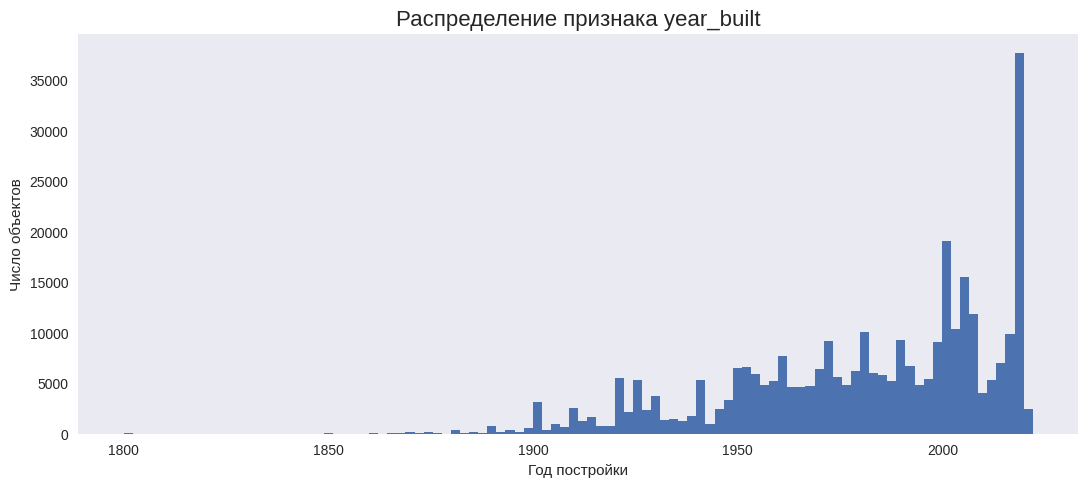

In [143]:
# Построим гистограмму распределения признака 
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0,0,1,1])
axes.hist(
    data['year_built'],
    bins=100
)
axes.set_title('Распределение признака year_built', fontsize=16)
axes.set_xlabel('Год постройки')
axes.set_ylabel('Число объектов')
axes.grid();

Признак remodeled_year содержит больше половины пропусков. Корректно восполнить данные не получится, придется его удалить. Заодно избавимся и от признака property_style - в нем 94% пропусков и никакой возможности их обыграть.

In [144]:
data = data.drop(['remodeled_year', 'property_style'], axis = 1)

### Признак beds

Число спален в признаке распределено абсолютно нелогично. Значения варьируются от 0 до 48. Казалось бы, должна быть привязка к жилплощади - чем больше площадь дома, тем больше спален. Но и тут подвох - многие многоквартирные дома видимо указывают общее число спален (квартир) и при этом площадь указана как на 1 квартиру. И даже для частных домов одного типа четкой зависимости тут нет.

In [145]:
data.beds.unique()

array([ 4.,  3.,  5.,  2., nan,  8.,  1.,  6., 12., 14.,  7.,  9.,  0.,
       16., 13., 10., 20., 11., 22., 15., 28., 32., 19., 18., 24., 17.,
       47., 23., 44., 30., 40., 34., 29., 26., 42., 21., 46., 36.])

In [146]:
# Заменим нулевое число спален (возможно это студии) на 0.5 и добавим отдельный признак beds_area (площадь на одну спальню)
data.loc[data['beds'] == 0, 'beds'] = 0.5
data['beds_area'] = data['sqft'] / data['beds']

Жилплощадь на одну спальню - это условный показатель того, что объект реальный и типовой. Сильнее всего зависит от конкретного местонахождения объекта недвиджимости (zipcode) и типа недвижимости (property_main_type). Попробуем использовать эту зависимость, чтобы заполнить пропуски в признаке.

In [147]:
# Заполним пустые значения в новом признаке средним по соответствующему типу недвижимости по каждому зипкоду
data['beds_area'] = data.groupby(['zipcode', 'property_main_type'])['beds_area'].transform(lambda x: x.fillna(x.mean()))
data['beds_area'] = data.groupby(['property_main_type'])['beds_area'].transform(lambda x: x.fillna(x.mean()))

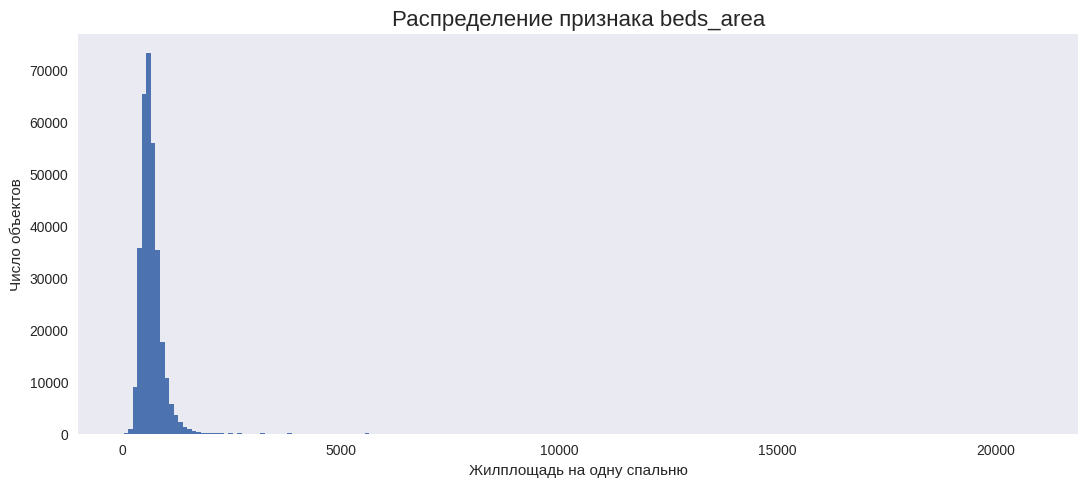

In [148]:
# Построим гистограмму распределения признака 
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0,0,1,1])
axes.hist(
    data['beds_area'],
    bins=200
)
axes.set_title('Распределение признака beds_area', fontsize=16)
axes.set_xlabel('Жилплощадь на одну спальню')
axes.set_ylabel('Число объектов')
axes.grid();

Распределение не нормально с пиком близ нуля и длинным хвостом вправо. Вновь воспользуемся методом z-отклонений для поиска выбросов. Для этого логарифмируем признак.

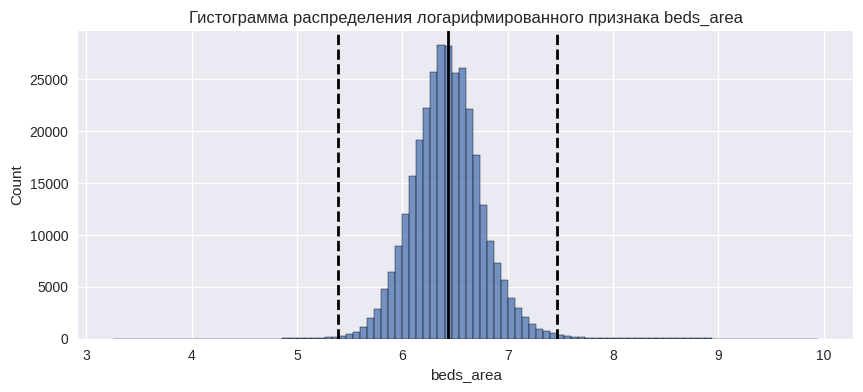

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
log_sqft = np.log(data['beds_area'])
histplot = sns.histplot(log_sqft, bins=100, ax=ax)
histplot.axvline(log_sqft.mean(), color='k', lw=2)
histplot.axvline(log_sqft.mean() + 3 *log_sqft.std(), color='k', ls='--', lw=2)
histplot.axvline(log_sqft.mean() - 3 *log_sqft.std(), color='k', ls='--', lw=2)
histplot.set_title('Гистограмма распределения логарифмированного признака beds_area');

Распределение стало похоже на нормальное, при этом много значений идет далеко за правую границу интервала. Думаю стоит расширить ее до 3.5 стандартных отклонений. 

In [150]:
outliers, cleaned = find_outliers_z_score(data, 'beds_area', left=3, right=3.5, log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 2063
Результирующее число записей: 318822


In [151]:
cleaned.beds_area.describe()

count    318822.000000
mean        650.669121
std         221.510665
min         219.833333
25%         500.000000
50%         614.666667
75%         753.333333
max        2076.400000
Name: beds_area, dtype: float64

Таким образом, методом z-отклонений были отсеяны объекты с аномальным показателем жилплощади на одну спальню (менее 220 и более 2100 кв.футов на спальню).

In [152]:
data = cleaned.copy()
data.reset_index(drop=True, inplace=True)

Теперь можем вычислить и число спален в пропусках исходного признака beds

In [153]:
data.loc[data['beds'].isnull() == True, 'beds'] = data['sqft'] / data['beds_area']
data['beds'] = data['beds'].apply(lambda x: 0 if x <= 0.5 else round(x, 0)).astype(int)

In [154]:
data.beds.describe()

count    318822.000000
mean          3.293568
std           1.473100
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          36.000000
Name: beds, dtype: float64

### Признак baths

Ситуация тут похожа на то, что мы видели со спальнями. Попробуем обработать признак тем же способом.

In [155]:
data.baths.unique()

array([  3.5 ,   3.  ,   2.  ,   8.  ,    nan,   1.75,   4.  ,   5.  ,
         1.  ,   7.  ,   2.1 ,   2.5 ,   4.5 ,   6.  ,   5.5 ,   1.5 ,
         1.25,   9.  ,   2.25,  12.  ,   2.75,  10.  ,   0.  ,   7.5 ,
        11.  ,   6.5 ,  19.  ,  13.  ,   1.1 , 241.  ,  10.5 ,  18.  ,
        20.  ,   3.1 ,  14.  ,   3.25,  16.  ,  24.  ,   9.5 ,  15.  ,
         3.75,  22.  ,   8.5 ,   5.2 ,  21.  ,   2.2 ,  25.  ,  12.5 ,
         4.25,   4.75,   0.75,   4.1 ,  23.  ,   5.25,  41.  ,  17.  ,
        30.  ,  11.5 ,   3.2 ,   6.75])

In [156]:
# Заменим нулевое число спален на 0.5 и добавим отдельный признак baths_area (площадь на одну ванну)
data.loc[data['baths'] == 0, 'baths'] = 0.5
data['baths_area'] = data['sqft'] / data['baths']

In [157]:
# Заполним пустые значения в новом признаке средним по соответствующему типу недвижимости по каждому зипкоду
data['baths_area'] = data.groupby(['zipcode', 'property_main_type'])['baths_area'].transform(lambda x: x.fillna(x.mean()))
data['baths_area'] = data.groupby(['property_main_type'])['baths_area'].transform(lambda x: x.fillna(x.mean()))

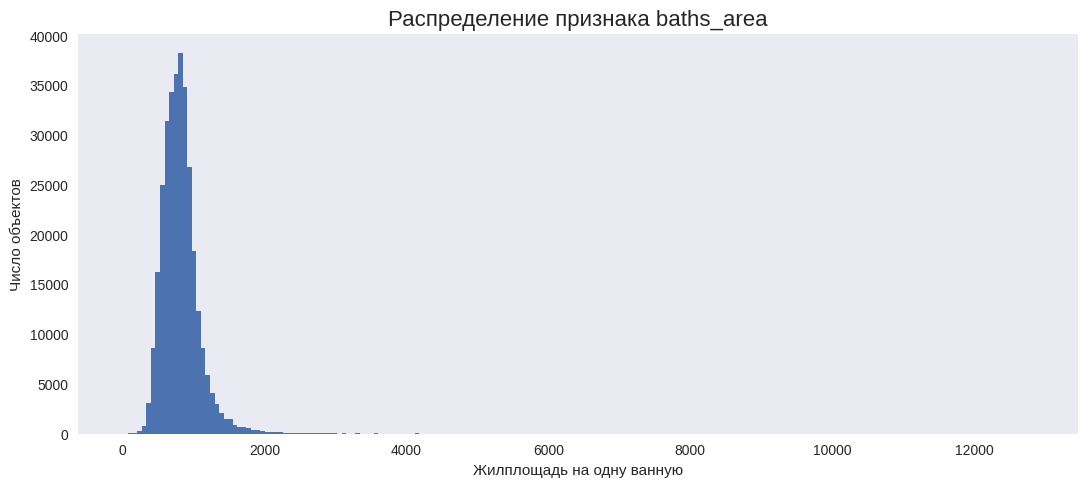

In [158]:
# Построим гистограмму распределения признака 
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0,0,1,1])
axes.hist(
    data['baths_area'],
    bins=200
)
axes.set_title('Распределение признака baths_area', fontsize=16)
axes.set_xlabel('Жилплощадь на одну ванную')
axes.set_ylabel('Число объектов')
axes.grid();

Распределение не нормально с пиком близ нуля и длинным хвостом вправо. Вновь воспользуемся методом z-отклонений для поиска выбросов. Для этого логарифмируем признак.

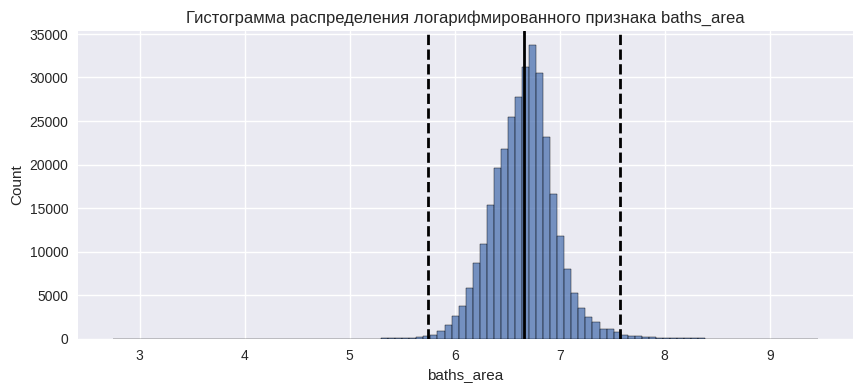

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
log_sqft = np.log(data['baths_area'])
histplot = sns.histplot(log_sqft, bins=100, ax=ax)
histplot.axvline(log_sqft.mean(), color='k', lw=2)
histplot.axvline(log_sqft.mean() + 3 *log_sqft.std(), color='k', ls='--', lw=2)
histplot.axvline(log_sqft.mean() - 3 *log_sqft.std(), color='k', ls='--', lw=2)
histplot.set_title('Гистограмма распределения логарифмированного признака baths_area');

Распределение стало похоже на нормальное, при этом много значений попало за границы интервала. Думаю стоит расширить его вправо до 3.5 стандартных отклонений. 

In [160]:
outliers, cleaned = find_outliers_z_score(data, 'baths_area', left=3, right=3.5, log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 2039
Результирующее число записей: 316783


In [161]:
cleaned.baths_area.describe()

count    316783.000000
mean        813.554884
std         245.109121
min         312.363636
25%         646.722222
50%         789.960997
75%         931.333333
max        2277.000000
Name: baths_area, dtype: float64

In [162]:
data = cleaned.copy()
data.reset_index(drop=True, inplace=True)

Теперь можем вычислить и число ванных в пропусках исходного признака baths

In [163]:
data.loc[data['baths'].isnull() == True, 'baths'] = data['sqft'] / data['baths_area']

In [164]:
# Будем считать, что нуля ванных в доме быть не может, будем считать их за 1, остальные значения округлим до целого
data['baths'] = data['baths'].apply(lambda x: 1 if x <= 1 else round(x, 0)).astype(int)

In [165]:
data.baths.unique()

array([ 4,  3,  2,  8,  5,  1,  7,  6,  9, 12, 11, 10, 14, 13, 16, 15, 18,
       20, 24, 17, 21, 22, 19])

### Признак lotsize_acres

In [166]:
data.lotsize_acres.describe()

count    235544.000000
mean          2.201580
std         151.131812
min           0.000023
25%           0.114853
50%           0.178375
75%           0.290000
max       49299.440000
Name: lotsize_acres, dtype: float64

Разброс значений в признаке очень велик, при этом 75% объектов имеют участок менее 0.3 акра. Считаю, что лучше будет преобразовать признак обратно в кв.футы.

И сразу стоит отбросить из данных самые большие объекты более 100 акров, так как такая площадь участка уж очень велика для одного дома, даже если это дворец или жилой комплекс.

In [167]:
data = data[(data['lotsize_acres'] < 100) | (data['lotsize_acres'].isnull() == True)]
data.reset_index(drop=True, inplace=True)

data['lotsize_sqft'] = data['lotsize_acres'] * 43560
data = data.drop(['lotsize_acres'], axis = 1)

In [168]:
# Размер участка в 1 кв.фут это скрытые пропуски в данных, заменим их на nan
data.loc[data['lotsize_sqft'] <= 1, 'lotsize_sqft'] = np.nan

In [169]:
# Заполним пропуски медианными значениями для разных типов недвижимости по каждому зипкоду
data['lotsize_sqft'] = data.groupby(['zipcode', 'property_add_type'])['lotsize_sqft'].transform(lambda x: x.fillna(x.median()))
data['lotsize_sqft'] = data.groupby(['state', 'property_add_type'])['lotsize_sqft'].transform(lambda x: x.fillna(x.median()))
data['lotsize_sqft'] = data.groupby(['property_add_type'])['lotsize_sqft'].transform(lambda x: x.fillna(x.median()))

In [170]:
data.lotsize_sqft.describe()

count    3.165430e+05
mean     2.330581e+04
std      1.272717e+05
min      3.000000e+00
25%      4.482000e+03
50%      7.405000e+03
75%      1.168950e+04
max      4.334220e+06
Name: lotsize_sqft, dtype: float64

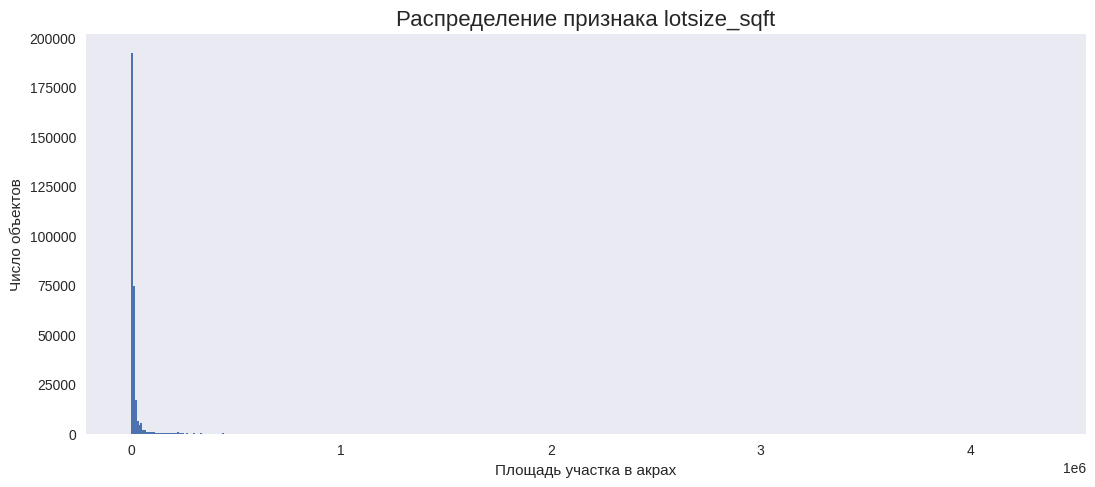

In [171]:
# Построим гистограмму распределения признака 
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0,0,1,1])
axes.hist(
    data['lotsize_sqft'],
    bins=500
)
axes.set_title('Распределение признака lotsize_sqft', fontsize=16)
axes.set_xlabel('Площадь участка в акрах')
axes.set_ylabel('Число объектов')
axes.grid();

Распределение не нормально с пиком близ нуля и длинным хвостом вправо. Вновь воспользуемся методом z-отклонений для поиска выбросов. Для этого логарифмируем признак.

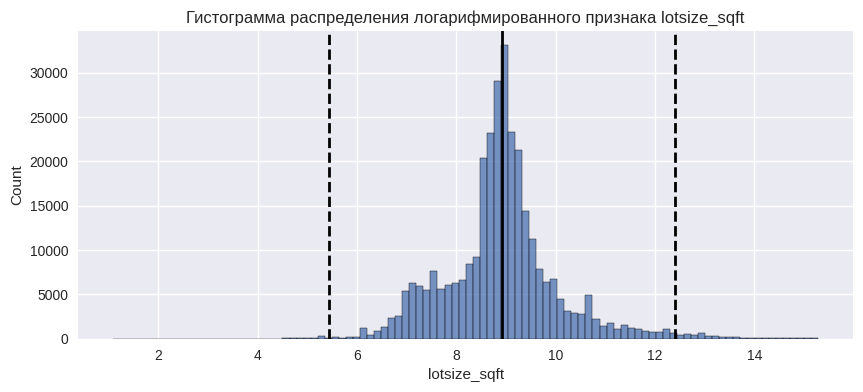

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
log_sqft = np.log(data['lotsize_sqft'])
histplot = sns.histplot(log_sqft, bins=100, ax=ax)
histplot.axvline(log_sqft.mean(), color='k', lw=2)
histplot.axvline(log_sqft.mean() + 3 *log_sqft.std(), color='k', ls='--', lw=2)
histplot.axvline(log_sqft.mean() - 3 *log_sqft.std(), color='k', ls='--', lw=2)
histplot.set_title('Гистограмма распределения логарифмированного признака lotsize_sqft');

Распределение стало похоже на нормальное, при этом много значений попало за границы интервала. Думаю стоит расширить его вправо до 3.5 стандартных отклонений. 

In [173]:
outliers, cleaned = find_outliers_z_score(data, 'lotsize_sqft', left=3, right=3, log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 4931
Результирующее число записей: 311612


In [174]:
cleaned.lotsize_sqft.describe()

count    311612.000000
mean      13328.020127
std       24372.456500
min         229.000000
25%        4425.000000
50%        7405.000000
75%       11325.600000
max      244589.400000
Name: lotsize_sqft, dtype: float64

Таким образом, методом z-отклонений были отсеяны объекты с площадью участка (менее 200 кв.футов и более 250 тыс кв.футов ~ 2.5 гектара).

In [175]:
data = cleaned.copy()
data.reset_index(drop=True, inplace=True)

In [176]:
# Посмотрим не осталось ли пропусков в данных (в процентах)
data.isna().sum().sort_values(ascending=False) / len(data) * 100

status                  0.0
baths                   0.0
baths_area              0.0
beds_area               0.0
school_mean_distance    0.0
school_min_distance     0.0
school_rating           0.0
private_pool            0.0
property_add_type       0.0
property_main_type      0.0
parking                 0.0
cooling                 0.0
heating                 0.0
year_built              0.0
target                  0.0
stories                 0.0
state                   0.0
beds                    0.0
zipcode                 0.0
sqft                    0.0
fireplace               0.0
lotsize_sqft            0.0
dtype: float64

In [177]:
# Проверим, не появились ли дубли
data.duplicated().sum()

113

In [178]:
# Удалим дубли
data = data.drop_duplicates(ignore_index=True)
data.duplicated().sum()

0

In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311499 entries, 0 to 311498
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                311499 non-null  object 
 1   baths                 311499 non-null  int64  
 2   fireplace             311499 non-null  int64  
 3   sqft                  311499 non-null  float64
 4   zipcode               311499 non-null  int64  
 5   beds                  311499 non-null  int64  
 6   state                 311499 non-null  object 
 7   stories               311499 non-null  object 
 8   target                311499 non-null  int64  
 9   year_built            311499 non-null  float64
 10  heating               311499 non-null  int64  
 11  cooling               311499 non-null  int64  
 12  parking               311499 non-null  int64  
 13  property_main_type    311499 non-null  object 
 14  property_add_type     311499 non-null  object 
 15  

## Анализ признаков

Осталось разобраться, что представляют из себя обработанные признаки и могут ли они быть использованы в модели машинного обучения. 

In [180]:
data.describe()

baths      fireplace           sqft        zipcode  \
count  311499.000000  311499.000000  311499.000000  311499.000000   
mean        2.639026       0.303535    2133.169193   52814.419282   
std         1.336041       0.459785    1232.017845   26762.249515   
min         1.000000       0.000000     333.000000    1103.000000   
25%         2.000000       0.000000    1314.000000   33056.000000   
50%         2.000000       0.000000    1845.000000   37406.000000   
75%         3.000000       1.000000    2571.000000   77845.000000   
max        24.000000       1.000000   10818.000000   99338.000000   

                beds        target     year_built        heating  \
count  311499.000000  3.114990e+05  311499.000000  311499.000000   
mean        3.294701  5.534103e+05    1980.717267       0.767784   
std         1.459411  7.823387e+05      32.434354       0.422247   
min         0.000000  9.900000e+03    1800.000000       0.000000   
25%         2.000000  2.149000e+05    1959.000000       1.000000   
50%         3.000000  3.350000e+05    1988.000000       1.000000   
75%         4.000000  5.790000e+05    2006.000000       1.000000   
max        36.000000  1.000000e+07    2022.000000       1.000000   

             cooling        parking   private_pool  school_rating  \
count  311499.000000  311499.000000  311499.000000  311499.000000   
mean        0.715774       0.535819       0.132601       5.168097   
std         0.451046       0.498716       0.339143       1.927178   
min         0.000000       0.000000       0.000000       1.000000   
25%         0.000000       0.000000       0.000000       3.700000   
50%         1.000000       1.000000       0.000000       5.000000   
75%         1.000000       1.000000       0.000000       6.500000   
max         1.000000       1.000000       1.000000      10.000000   

       school_min_distance  school_mean_distance      beds_area  \
count        311499.000000         311499.000000  311499.000000   
mean              1.035144              2.717952     649.081101   
std               1.408655              2.889100     219.191253   
min               0.020000              0.020000     219.833333   
25%               0.360000              1.040000     500.000000   
50%               0.630000              1.710000     613.333333   
75%               1.200000              3.030000     751.687500   
max              26.670000             27.240000    2076.400000   

          baths_area   lotsize_sqft  
count  311499.000000  311499.000000  
mean      813.404746   13328.026848  
std       244.190094   24371.686678  
min       312.363636     229.000000  
25%       648.000000    4426.000000  
50%       790.000000    7405.000000  
75%       931.000000   11325.600000  
max      2277.000000  244589.400000

### Числовые признаки

До подачи признаков в модель нужно понимать, какого рода распределение мы имеем. От этого зависит и выбор оптимальной модели и способ нормализации/стандартизации данных. На первых этапах работы мы видели, что исходные распределения признаков не были нормальными. Однако, логарифмирование приводило их к виду, похожему на нормальное.

Проверим статистическими тестами на нормальность наши гипотезы.

In [181]:
# Сделаем копию датасета, в которм логарифмируем все непрерывные числовые признаки
data_log = data.copy()
for column in ['sqft', 'school_rating', 'beds_area', 'baths_area', 'lotsize_sqft', 'target']:
    data_log[column] = np.log(data[column])
for column in ['school_min_distance', 'school_mean_distance']:
    data_log[column] = np.log(data[column]+1)

In [182]:
# Формулируем гипотезы, задаем уровень значимости
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05 

In [183]:
# Делаем проверку на нормальность всех числовых признаков тестом Шапиро-Уилка (но для больших выборок он не точен)
for i in ['sqft', 'school_rating', 'beds_area', 'baths_area', 'lotsize_sqft', 'school_min_distance', 'school_mean_distance', 'target']:
    _, p = shapiro(data_log[i])
    print('Признак', i, )
    if p > alpha:
        print('p=%.3f' % p, H0)
    else:
        print('p=%.3f' % p, Ha)

Признак sqft
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак school_rating
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак beds_area
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак baths_area
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак lotsize_sqft
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак school_min_distance
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак school_mean_distance
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак target
p=0.000 Данные не распределены нормально (мы отвергаем H0)


In [184]:
# Делаем проверку на нормальность всех числовых признаков тестом Д’Агостино
for i in ['sqft', 'school_rating', 'beds_area', 'baths_area', 'lotsize_sqft', 'school_min_distance', 'school_mean_distance', 'target']:
    _, p = normaltest(data_log[i])
    print('Признак', i)
    if p > (alpha*0.5):
        print('p=%.3f' % p, H0)
    else:
        print('p=%.3f' % p, Ha)

Признак sqft
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак school_rating
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак beds_area
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак baths_area
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак lotsize_sqft
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак school_min_distance
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак school_mean_distance
p=0.000 Данные не распределены нормально (мы отвергаем H0)
Признак target
p=0.000 Данные не распределены нормально (мы отвергаем H0)


Получается, что распределения логарифмированных числовых признаков все же не являются нормальными, хоть и визуально очень близки к этому. Эта информация еще пригодится нам при выборе способа нормализации данных.

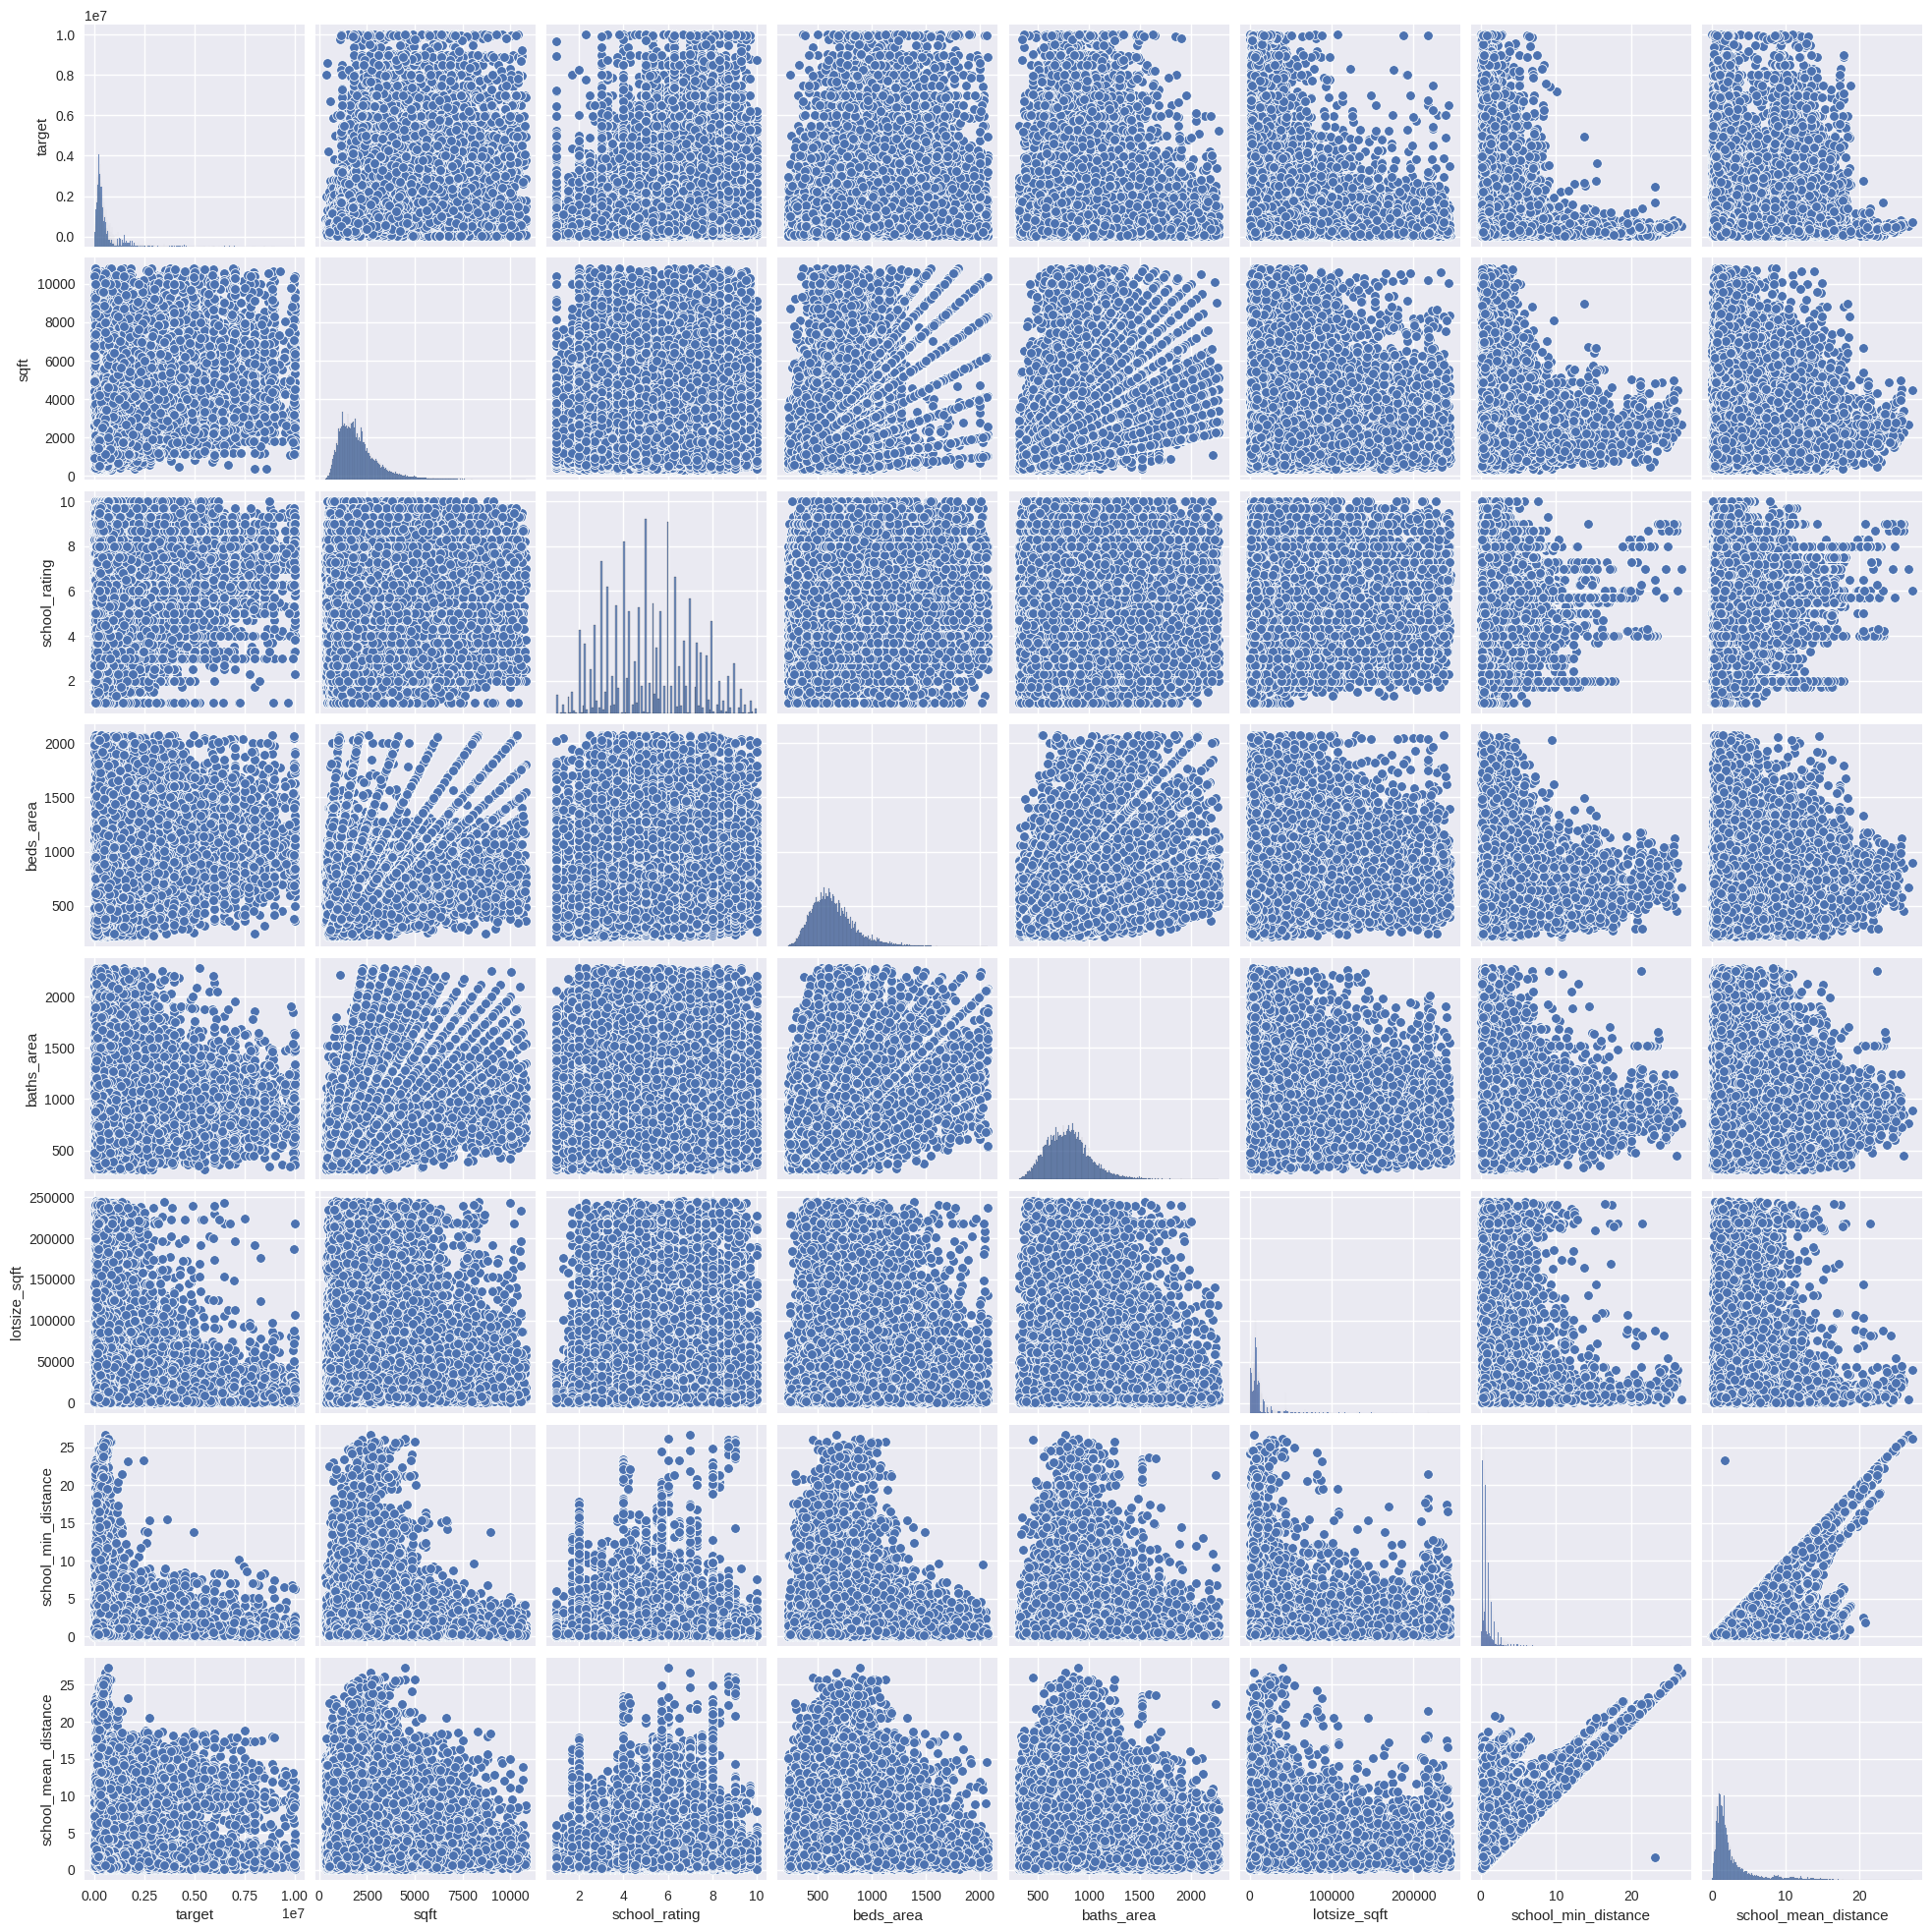

In [185]:
# Построим график попарных отношений для непрерывных числовых признаков
data_num = data[['target', 'sqft', 'school_rating', 'beds_area', 'baths_area', 'lotsize_sqft', 'school_min_distance', 'school_mean_distance']]
sns.pairplot(data_num)

Из диаграмм рассеяния можно сделать несколько выводов:
- большинство объектов имеют типовые признаки и массово группируются ближе к началу осей координат;
- единичные объекты выбиваются из общей картины, но в целом большую долю выбросов мы уловили и очистили данные от них;
- по графикам не наблюдается сильной коллинеарности признаков с целевой переменной.

Кроме непрерывных числовых признаков в датасете имеется ряд порядковых числовых признаков. Посмотрим, какие зависимости имеются между ними.

In [186]:
# Этажность здания тоже порядковый признак, но у нас он в строковом формате, преобразуем значения к нужному виду    
for i, value in enumerate(['one', 'two', 'tri', 'multi']):
    data.loc[data['stories'] == value, 'stories'] = i
data['stories'] = data['stories'].astype(int)

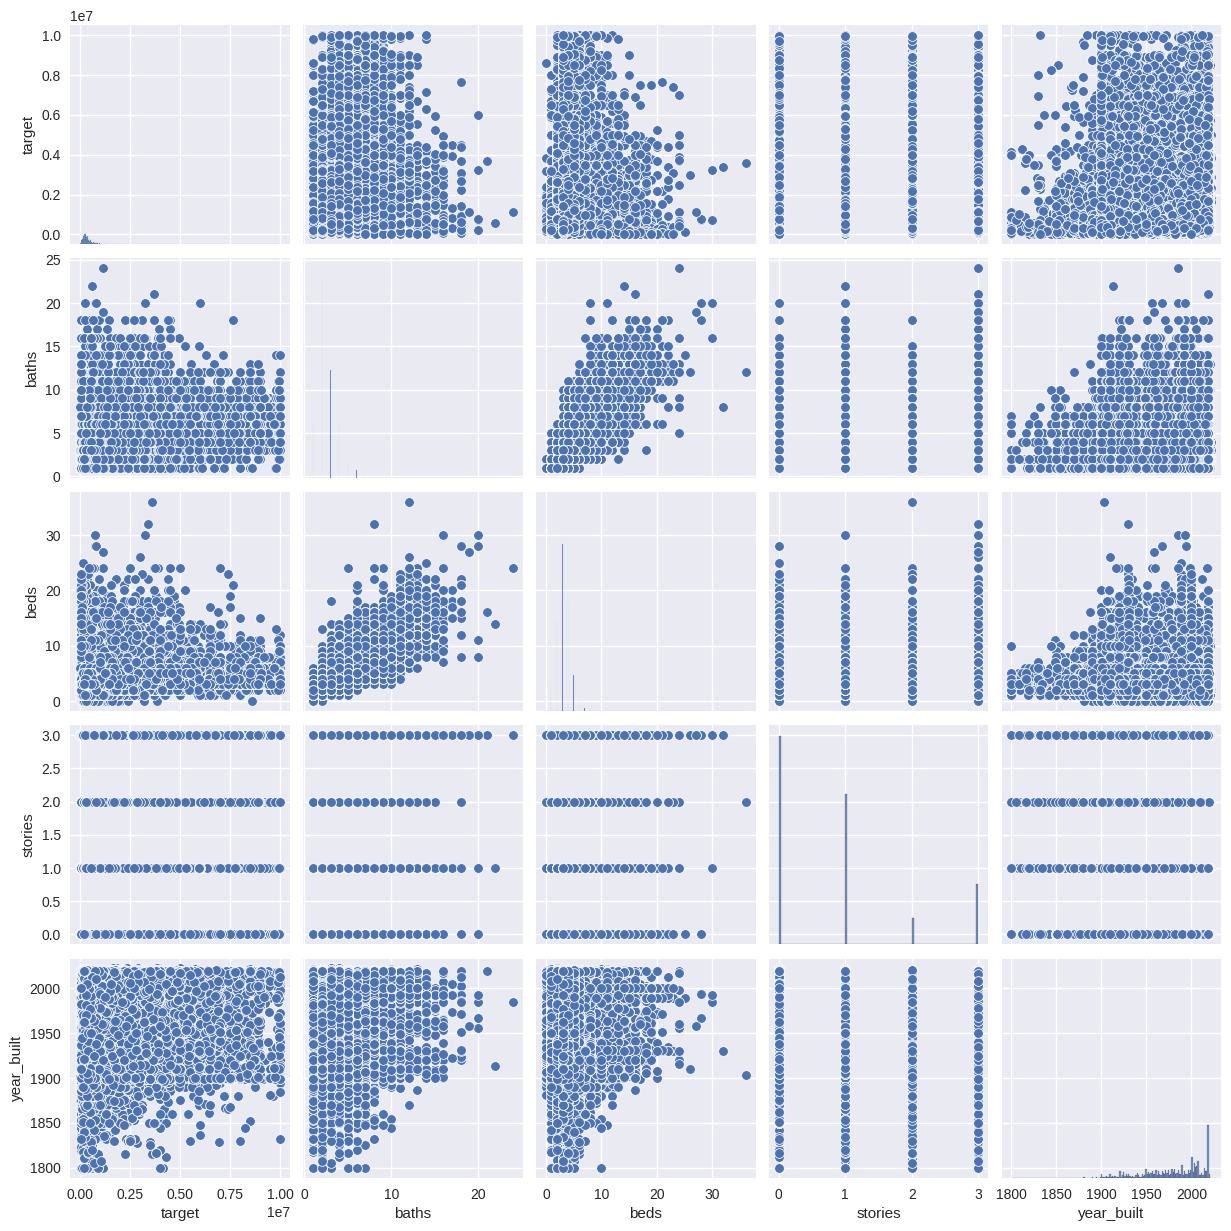

In [187]:
# Построим график попарных отношений для порядковых числовых признаков и целевого
data_label = data[['target', 'baths', 'beds', 'stories', 'year_built']]
sns.pairplot(data_label)

По распределениям порядковых признаков также не вижу серьезных аномалий - распределения строятся ожидаемо тому, что мы наблюдали при предобработке данных.

Построим тепловую матрицу корреляций, чтобы увидеть общую картину корреляций между парами признаков в датасете. 

<AxesSubplot: >

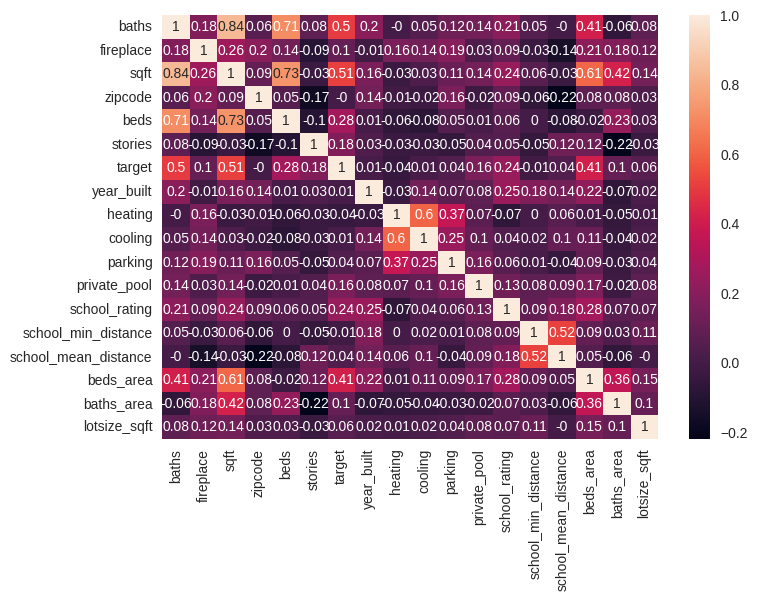

In [188]:
sns.heatmap(round(data.corr(), 2), annot=True)

Целевой признак target не имеет сильной корреляции ни с одним из признаков датасета.

С другой стороны наблюдается мультиколлинеарность между признаками baths, beds и sqft. От какого-то из них придется избавиться на этапе отбора признаков для модели.

### Категориальные признаки

Построим сводные графики joinplot, чтобы посмотреть на распределения признаков и оценить их взаимосвязи.

In [ ]:
#or i in ['status', 'state', 'property_main_type', 'property_add_type']:

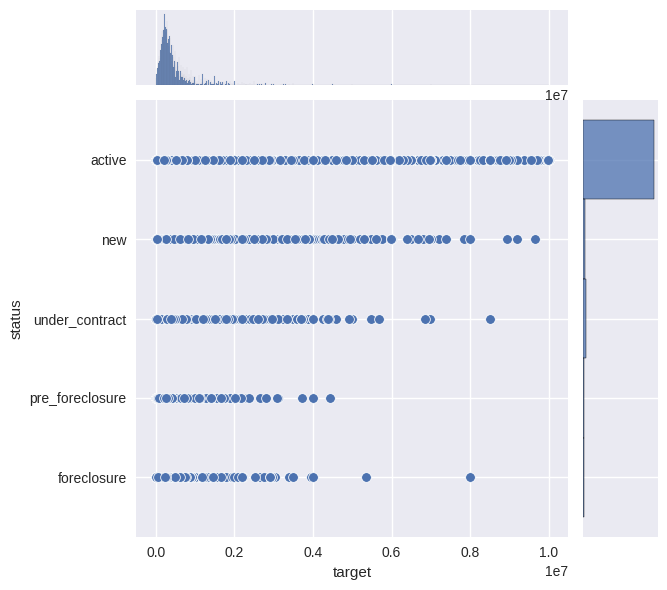

In [221]:
sns.jointplot(data, x='target', y='status')

Видим, что цена недвижимости зависит от статуса объекта. Больше всего в данных объектов с активным статусом, для них и самый потолок цен.

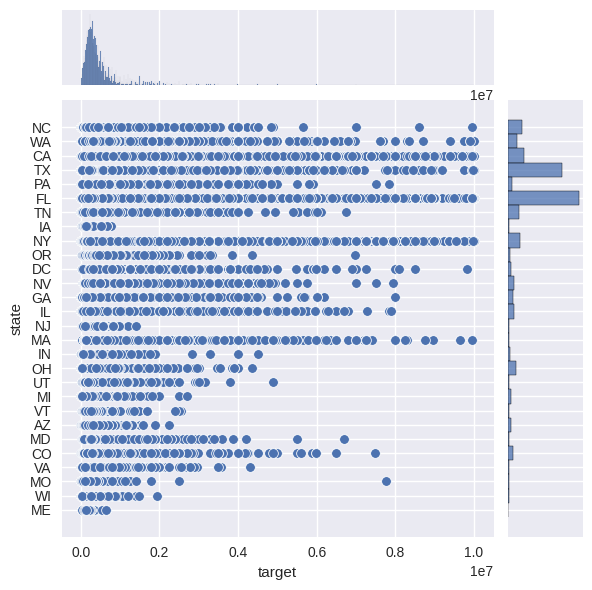

In [223]:
sns.jointplot(data, x='target', y='state')

Хорошо заметно, как меняются дипапзон цен а недвижимость в зависимости от штата. Считаю, что это важный признак для построения модели.

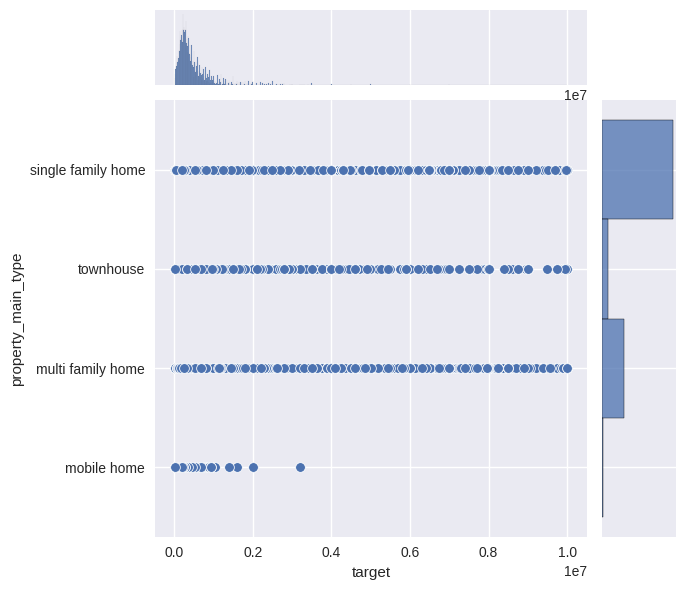

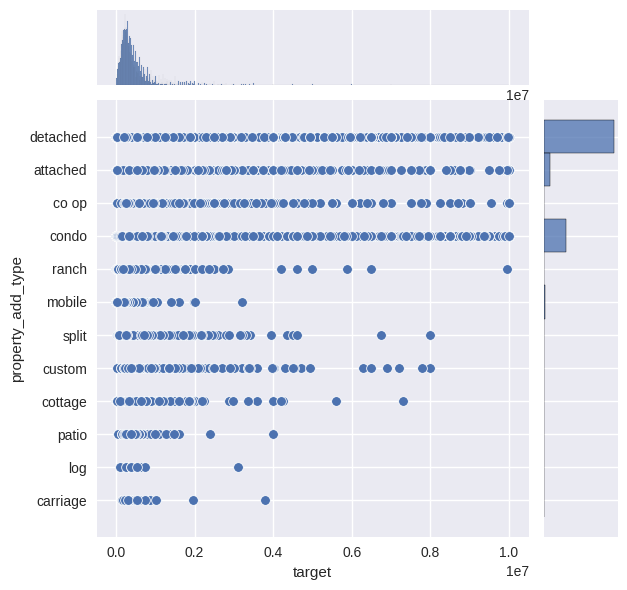

In [225]:
sns.jointplot(data, x='target', y='property_main_type')
sns.jointplot(data, x='target', y='property_add_type')

На графиках прослеживается зависимость цены от типа недвижимости. Но в самых многочисленных категориях (частные дома, квартиры, таунхаусы) ценовой диапазон очень размыт, это может усложнить работу алгоритма. 

Таким образом, на основе анализа зависимостей в данных, прихожу к выводу, что признаки beds, school_mean_distance и property_main_type  

Забегая вперед, скажу, что я протестировал разные модели с этими признаками и без них, и предположения подтвердились, эти признаки только ухудшают метрики в большинстве опробованных моделей.

И это вполне объяснимо:
- beds имеет сильную корреляцию с признаком sqft, что мы видели на тепловой матрице корреляций;
- school_mean_distance коррелирует с признаком school_min_distance, ведь эти признаки были выделены из одних и тех же данных;
- property_main_type - это категориальный признак, который обобщает в более крупные группы категории из property_add_type, по сути не является информативным.

Данные признаки в модели подавать не будем, нужно их удалить.

In [226]:
data = data.drop(['beds', 'school_mean_distance', 'property_main_type'], axis=1)

Сохраним итоговую версию датасета для использования ее в моделировании и при построении веб-сервиса. 

In [227]:
data.to_csv('data/data_cleaned.csv', index=False)